# Adversarial examples - Blind spot in representation spaces
### Author: Pietro Gori

As for all TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus/web site the deadline

In [26]:
import numpy as np
import random

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset

# torchvision
from torchvision import models,transforms
import torchvision.datasets as Data

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline
from tqdm import tqdm
import time

In this practical session, you will produce adversarial examples using two strategies to analyse the quality and smoothness of a representation space. We will use the Mnist dataset and a simple network (with 97% accuracy on test though...) so that you can train and test on your own laptop. Same conclusions can be drawn by using larger architectures and more complex datasets (You can try if you want).

Let's start with the first method. Please read first the article [1], in particular from Sectioon 4. 

`[1] Szegedy, Christian, Zaremba, Wojciech, Sutskever, Ilya, Bruna, Joan, Erhan, Dumitru, Goodfellow, Ian J.,
and Fergus, Rob. Intriguing properties of neural networks. ICLR, 2014`

We first check if you are using a computer with GPU, CUDA (Nvidia) or MPS (MacBook), or only CPU. 

In [27]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)    
    print ("MPS (MacBook) device found.")
    print('Number of MPS cards: ', torch.mps.device_count())
    print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print(x) 
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   x = torch.ones(1, device=device)
   print(x) 
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.1.2
tensor([1.])
No MPS or CUDA has been found. PyTorch will use CPU.


Here we fix the different seeds to make your algorithm reproducible and we set the hyper-parameters for the classification model we are going to train. You can modify them if you want, but I suggest you keep them like that for now and modify them only AFTER having trained for a first time the model. 

In [28]:
# to make the results reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
torch.mps.manual_seed(10)
random.seed(10)


# Parameters for training model
weight_decay = 0
num_epochs = 5
batch_size=256 # adapted to the Google Colab GPU
learning_rate=0.001
loss_model=nn.CrossEntropyLoss()

We will use the MNIST dataset. Download it from torchvision.

In [29]:
mnist_train = Data.MNIST(root='data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

train_loader  = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)

mnist_test = Data.MNIST(root='data/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

test_loader  = DataLoader(dataset=mnist_test,
                                          batch_size=10000,
                                          shuffle=False)

We analyse the data to check the number of samples and their size.

In [30]:
# Print infomration
print("There are ", len (mnist_train), "training images and ", len(mnist_test), "test images")
image_size=list(mnist_train[0][0].squeeze().shape)
print(f"Each image is of shape: {image_size}")  # [28, 28]


There are  60000 training images and  10000 test images
Each image is of shape: [28, 28]


Here we code the model proposed in the article. 

**Question**: complete the code so that you can create *A simple fully connected network with one or more hidden layers and a Softmax classifier. We refer to this network as “FC”*. Please code it so that the input_size of the model (i.e. size of the input images), the number and size of hidden layers (e.g., [100,100]) and the output size (i.e., number of possible classes) are parameters of the model. 

In [31]:
  
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FullyConnectedNet, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        layers = []
        for i in range(len(layer_sizes) - 2):  
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))  
        self.model = nn.Sequential(*layers)
        self.activation = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.flatten(1)
        x = self.model(x)
        return self.activation(x)


**Question**: Create one of the model proposed in the article.

In [32]:
input_size = 28*28
hidden_sizes = [128]
output_size = 10

# Model
model = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# Print the model
print(model)

FullyConnectedNet(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (activation): Softmax(dim=1)
)


Here we code the training procedure, as commonly done with Pytorch. Please note that we use the Adam optimizer.

In [33]:
def training(model, train_loader, optimizer, num_epochs, loss_model):
  for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        # Put images to GPU
        X = images.to(device)
        Y = labels.to(device)

        # Forward pass
        outputs = model(X)
        loss = loss_model(outputs, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

And we evaluate it.

In [34]:
def evaluation(model, test_loader):
  model.eval()

  correct = 0
  total = 0

  for images, labels in test_loader:

      X  = images.to(device)
      Y  = labels.to(device)

      outputs = model(X) # array of size [num test images, num classes]

      predicted_class = torch.argmax(outputs.data, dim=1) # faster

      total += len(Y)
      correct += (predicted_class == Y).sum()

  print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

# function to get the value 
def evaluation_bis(model, test_loader):
  model.eval()

  correct = 0
  total = 0

  for images, labels in test_loader:

      X  = images.to(device)
      Y  = labels.to(device)

      outputs = model(X) # array of size [num test images, num classes]

      predicted_class = torch.argmax(outputs.data, dim=1) # faster

      total += len(Y)
      correct += (predicted_class == Y).sum()
      return 100 * float(correct) / total

In [36]:
# Training loop
training(model, train_loader, optimizer, num_epochs, loss_model)


Epoch [1/5], Step [100/235], Loss: 1.5318
Epoch [1/5], Step [200/235], Loss: 1.5261
Epoch [2/5], Step [100/235], Loss: 1.5386
Epoch [2/5], Step [200/235], Loss: 1.5363
Epoch [3/5], Step [100/235], Loss: 1.5097
Epoch [3/5], Step [200/235], Loss: 1.5077
Epoch [4/5], Step [100/235], Loss: 1.5248
Epoch [4/5], Step [200/235], Loss: 1.4982
Epoch [5/5], Step [100/235], Loss: 1.4979
Epoch [5/5], Step [200/235], Loss: 1.4953


In [37]:
evaluation(model, test_loader)

Accuracy of test images: 95.720000 %


**Question**: Is the performance good ? Test different architectures (number and size of hidden layers). You can also try different hyper-parameters (weight decay, number of epochs, etc.). Use the "Occam's razor principle" to choose and justify your final model. 

The performance is quite good and beats $FC10(10^{-4})$, $FC10(10^{-2})$ and $FC10(1)$


In the next cell we do the comparison

In [ ]:
raise KeyboardInterrupt # prevent to execute the following code

In [94]:

model_2 = FullyConnectedNet(input_size, [256], output_size).to(device)
model_3 = FullyConnectedNet(input_size, [512], output_size).to(device)
model_4 = FullyConnectedNet(input_size, [128, 128], output_size).to(device)
models = [model, model_2, model_3, model_4]
weight_decays_updates = [0.1, 0.5, 1, 2, 10]
num_epochs_diff = [3, 4, 5, 6, 7]
perf_max = 0
for i in range(len(models))  :
    my_model = models[i] 
    for weight_decay_up in weight_decays_updates : 
        for num_epochs_up in num_epochs_diff : 
            optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay_up* weight_decay)
            training(my_model, train_loader, optimizer, num_epochs_up, loss_model)
            res = evaluation_bis(my_model, test_loader)
            print(f"Model {i}  with weight decay {weight_decay_up*weight_decay} and {num_epochs_up} epochs. The performance is {res}")
            print("------------------------------------------------------")
            if perf_max < res : 
                perf_max = res
                model_max_index = i
                weight_decay_max = weight_decay_up*weight_decay
                num_epochs_max = num_epochs_up
print('the best perf is achieved by the model', i, 'with a weight decay of', weight_decay_max, 'and', num_epochs_max, 'epochs')

            

Epoch [1/3], Step [100/235], Loss: 1.5424
Epoch [1/3], Step [200/235], Loss: 1.5338
Epoch [2/3], Step [100/235], Loss: 1.5454
Epoch [2/3], Step [200/235], Loss: 1.5361
Epoch [3/3], Step [100/235], Loss: 1.5251
Epoch [3/3], Step [200/235], Loss: 1.5297
Model 0  with weight decay 0.0 and 3 epochs. The performance is 94.24
------------------------------------------------------
Epoch [1/4], Step [100/235], Loss: 1.5358
Epoch [1/4], Step [200/235], Loss: 1.5042
Epoch [2/4], Step [100/235], Loss: 1.5106
Epoch [2/4], Step [200/235], Loss: 1.4835
Epoch [3/4], Step [100/235], Loss: 1.4962
Epoch [3/4], Step [200/235], Loss: 1.5190
Epoch [4/4], Step [100/235], Loss: 1.5083
Epoch [4/4], Step [200/235], Loss: 1.4975
Model 0  with weight decay 0.0 and 4 epochs. The performance is 96.19
------------------------------------------------------
Epoch [1/5], Step [100/235], Loss: 1.4769
Epoch [1/5], Step [200/235], Loss: 1.4972
Epoch [2/5], Step [100/235], Loss: 1.5111
Epoch [2/5], Step [200/235], Loss: 1

Here, you will code the method proposed in Sec. 4.1 of [1]. I copy/paste it here:

We denote by $f : R^m \rightarrow {1 . . . k}$ a classifier mapping image pixel value vectors to a discrete label set. We also assume that $f$ has an associated continuous loss function denoted by $\text{loss}_f : R^m × {1 . . . k} \rightarrow R^+$. For a given $x \in R^m$ image and target label $l \in {1 . . . k}$, we aim to solve the following box-constrained optimization problem:

• Minimize $||r||_2$ subject to:
1. $f(x + r) = l$
2. $x + r \in [0, 1]^m$


The minimizer $r$ might not be unique, but we denote one such $x + r$ for an arbitrarily chosen minimizer by $D(x, l)$. Informally, $x + r$ is the closest image to $x$ classified as $l$ by $f$. Obviously, $D(x, f(x)) = f(x)$, so this task is non-trivial only if $f(x) \neq l$. In general, the exact computation
of $D(x, l)$ is a hard problem, so we approximate it by using a box-constrained L-BFGS. Concretely, we find an approximation of $D(x, l)$ by performing line-search to find the minimum $c > 0$ for which the minimizer $r$ of the following problem satisfies $f(x + r) = l$.

• Minimize $c|r| + \text{loss}_f (x + r, l)$ subject to $x + r \in [0, 1]^m$

This penalty function method would yield the exact solution for $D(X, l)$ in the case of convex losses, however neural networks are non-convex in general, so we end up with an approximation in this case.

We start by setting the hyper-parameters of the L-BFGS method. Keep them like that for now. You will come back later to change them.

In [39]:
# Parameters adversarial example
index=666 # index test image to use

max_iter_search=300
initial_c = 0.000001  # Initial value of c
max_c = 0.01  # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c

epsilon_LBFGS = 1e-6  # Small value for line search stopping criterion
max_iter_LBFGS = 100  # Maximum iterations for L-BFGS
lr_LBFGS = 0.1  # Learning rate for L-BFGS

We can plot the chosen image

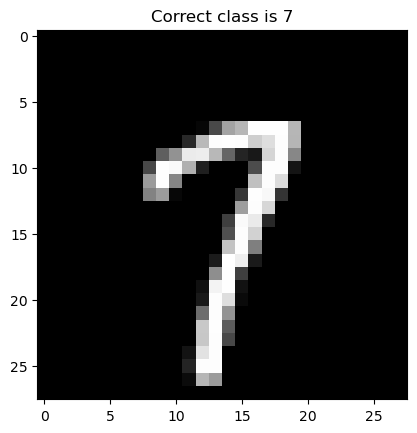

In [40]:
testI, testY = mnist_test.__getitem__(index)
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()


I have written a code to plot the original image $x$, the modified image $x+r$ and the residual added $r$.

In [41]:
def plot_results(X, r, Xr, Y, l, fail=True):

    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
    im1 = axes[0].imshow(X.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[0].set_title(f"Original Image. Correct class is {Y}",fontsize=22)

    im3=axes[2].imshow(r.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[2].set_title(f"Residual added",fontsize=22)

    if fail:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)    
        axes[1].set_title(f"Modified Image, FAILED to predict class {l.item()}",fontsize=22)
    else:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)    
        axes[1].set_title(f"Modified Image, PREDICTED class {l.item()}",fontsize=22)

    # Add a single colorbar for all subplots
    cbar = fig.colorbar(im3, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Intensity (0 to 1)')

    # Show the plots
    plt.show()

Here we will code the proposed method. Complete the code where you see `XXXXXXX`.

Please be advised that the `torch.optim.LBFGS` optimizer is designed to work with a `closure` for computing the loss and gradients multiple times during optimization, which is essential for second-order methods.

The closure is a callable function passed to LBFGS that recomputes the loss and its gradients multiple times during a single optimization step.
To work correctly, we need to call `optimizer.zero_grad()` to clear old gradients before calculating new ones.

Please note that SGD or Adam don't require a closure because they update the parameters based on the current gradient in a single step.

More info here: https://pytorch.org/docs/stable/optim.html

The true class is 7, the new class will be 8
Iter 20/300, Value of c: 0.000001
Iter 40/300, Value of c: 0.000001
Iter 60/300, Value of c: 0.000002
Iter 80/300, Value of c: 0.000002
Iter 100/300, Value of c: 0.000003
Iter 120/300, Value of c: 0.000003
Iter 140/300, Value of c: 0.000004
Iter 160/300, Value of c: 0.000005
Iter 180/300, Value of c: 0.000006
Found c = 0.000007 satisfying f(x + r) = l
Optimization succeeded with c = 0.000007 in 197 iterations
Norm Perturbation |r|: 96.7461166381836


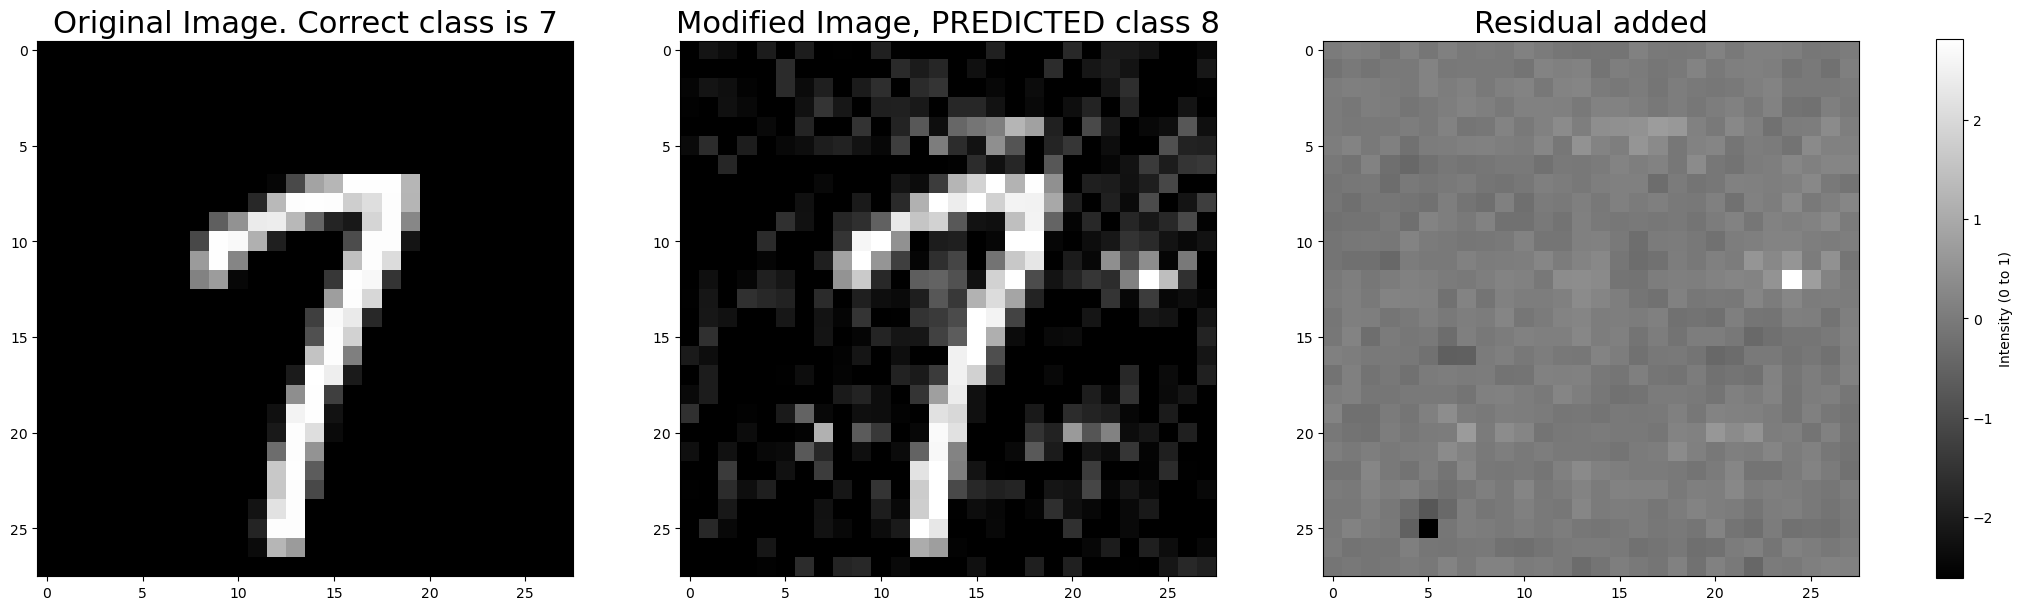

In [48]:
testI=testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
label=8 # manually chosen target class label different from true one
l = torch.tensor([label]).to(device)  
l=l.to(device)
l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")


# Define the loss function
def objective(c, r, x, l):
    los = c * torch.norm(r, p=1) + loss_model(model(x + r), l)
    return los


# Line search to find the minimum c > 0
c = 0.000001
iter=0
while (c <= max_c) and (iter <= max_iter_search):    
    # Define the optimizer (Box-Constrained L-BFGS)
    optimizerLBFGS = optim.LBFGS([r])

    def closure():
      optimizerLBFGS.zero_grad()
      loss = objective(c, r, testI, l)
      loss.backward()
      return loss

    # Perform optimization
    optimizerLBFGS.step(closure)


    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition f(x + r) = l is satisfied
    if predicted_label == l:
        print(f"Found c = {c:.6f} satisfying f(x + r) = l")
        iter=iter+1
        break
    else:
        iter=iter+1

    # If not satisfied, increase c
    c *= 1.01 # Adjust step size for line search
    if (iter) % 20 == 0:
        print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

if (c > max_c) or (iter > max_iter_search):
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=True)

else:
    print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=False)

**QUESTION** Try with different images and different predicted classes (l), does the algorithm always converge ? You can test with different hyper-parameters for c. When it converges, are the images semantically similar to the original one ? Visually, would you say that they should belong to the original or new class ? What's the average distortion (norm of r) ?

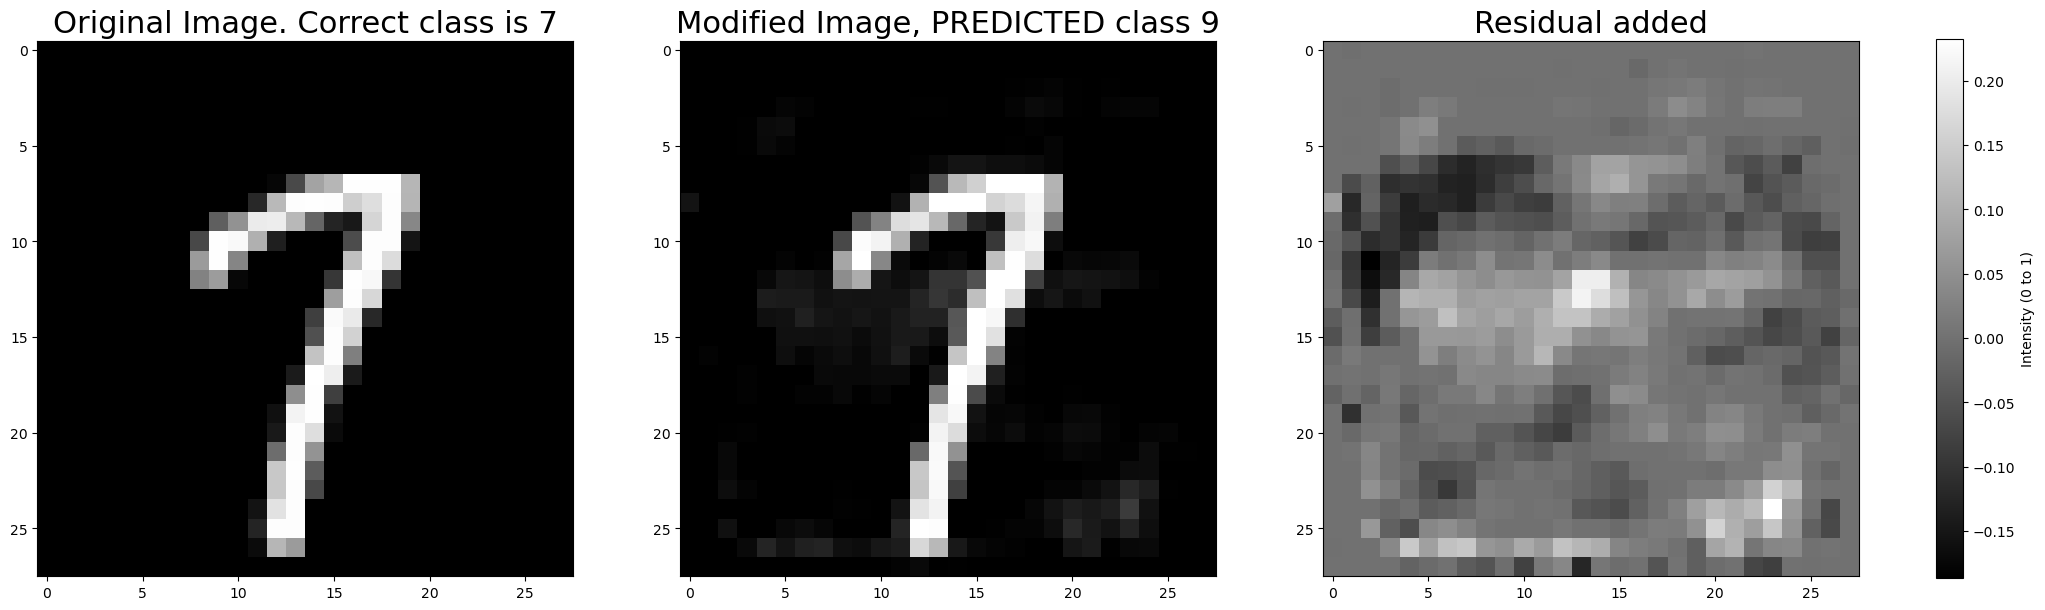

for image 666 of true label 7 and false label 9 the convergence is: True
for image 7391 of true label 4 and false label 3 the convergence is: False
for image 7068 of true label 6 and false label 8 the convergence is: False


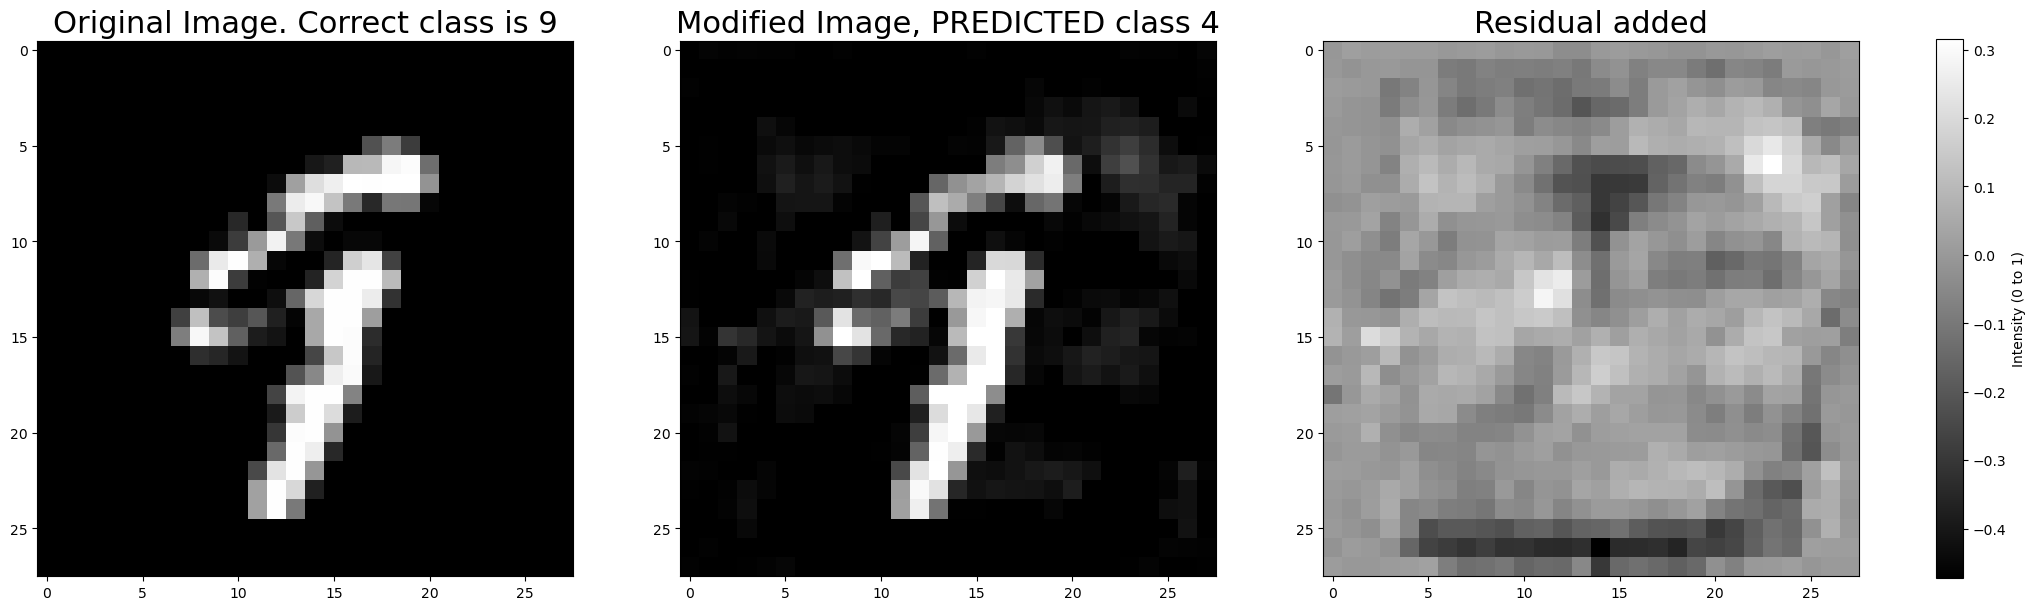

for image 9620 of true label 9 and false label 4 the convergence is: True
for image 3915 of true label 4 and false label 3 the convergence is: False


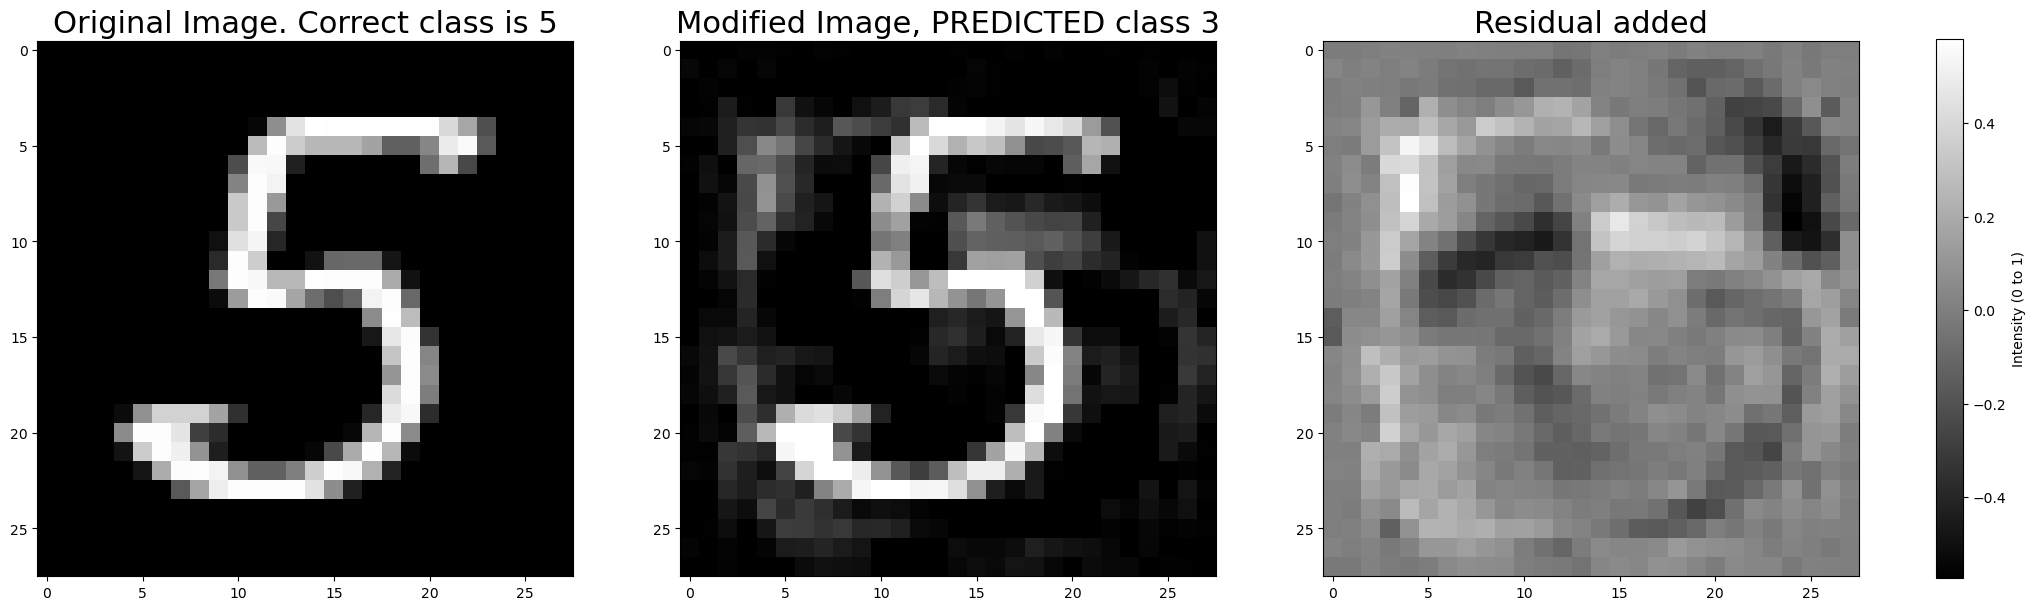

for image 5910 of true label 5 and false label 3 the convergence is: True


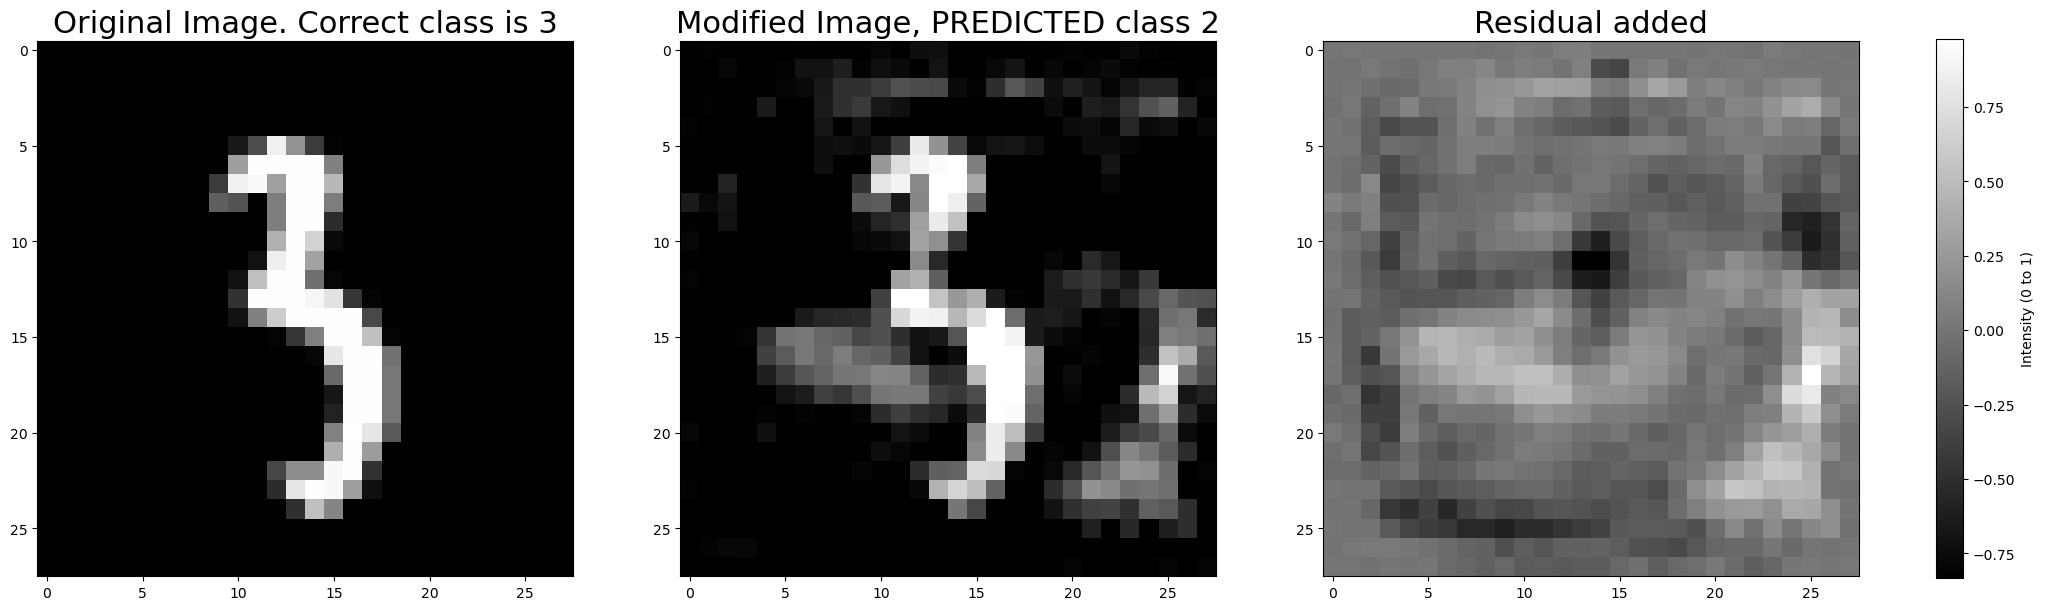

for image 1607 of true label 3 and false label 2 the convergence is: True
for image 3234 of true label 4 and false label 7 the convergence is: False
for image 8744 of true label 6 and false label 3 the convergence is: False
for image 5589 of true label 8 and false label 2 the convergence is: False
for image 474 of true label 8 and false label 1 the convergence is: False
for image 1808 of true label 0 and false label 3 the convergence is: False
for image 3814 of true label 5 and false label 3 the convergence is: False
for image 5264 of true label 2 and false label 6 the convergence is: False
for image 4713 of true label 2 and false label 6 the convergence is: False


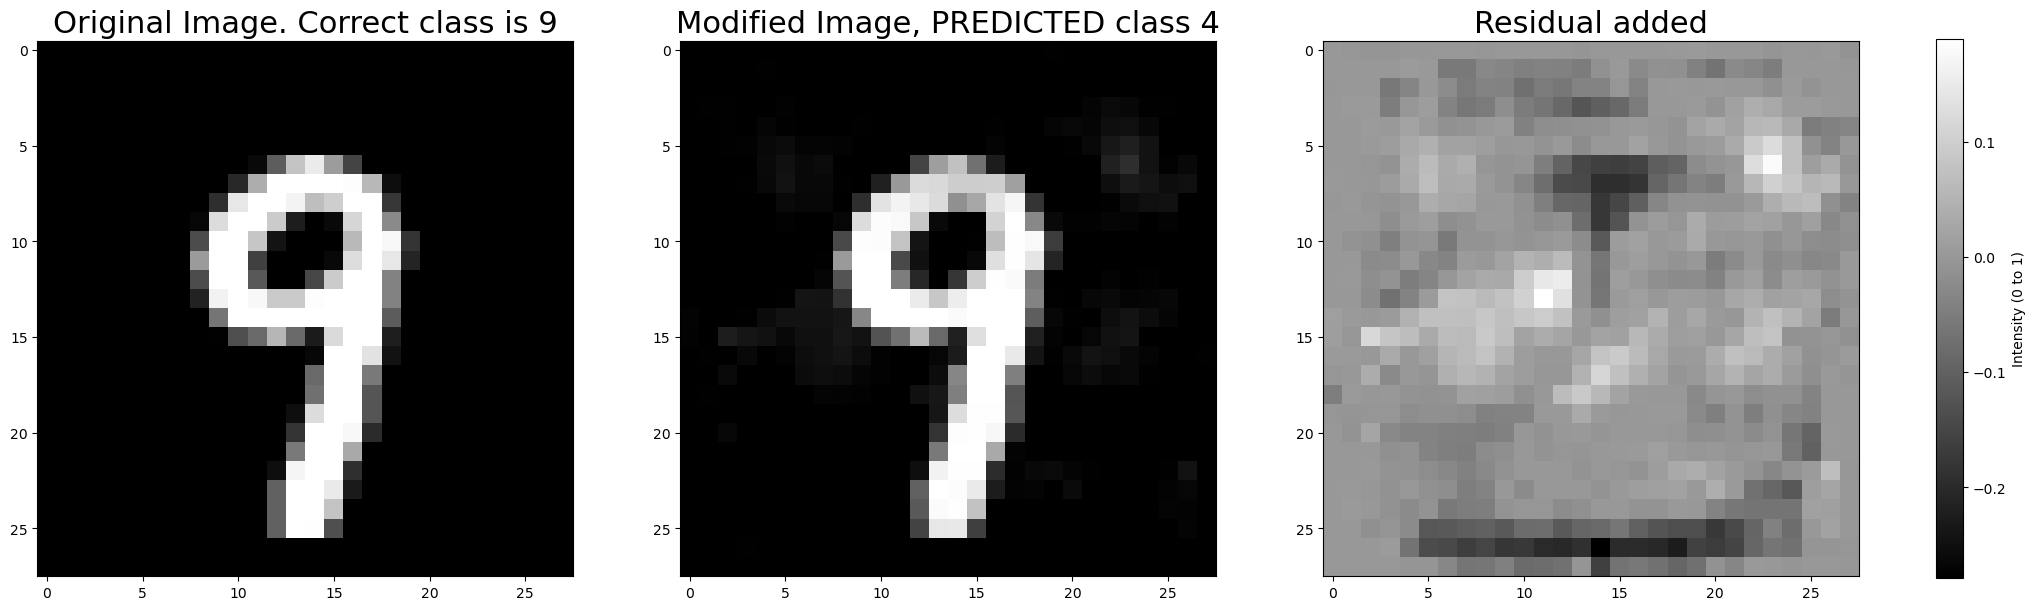

for image 5375 of true label 9 and false label 4 the convergence is: True
for image 7138 of true label 1 and false label 9 the convergence is: False
for image 9222 of true label 1 and false label 8 the convergence is: False


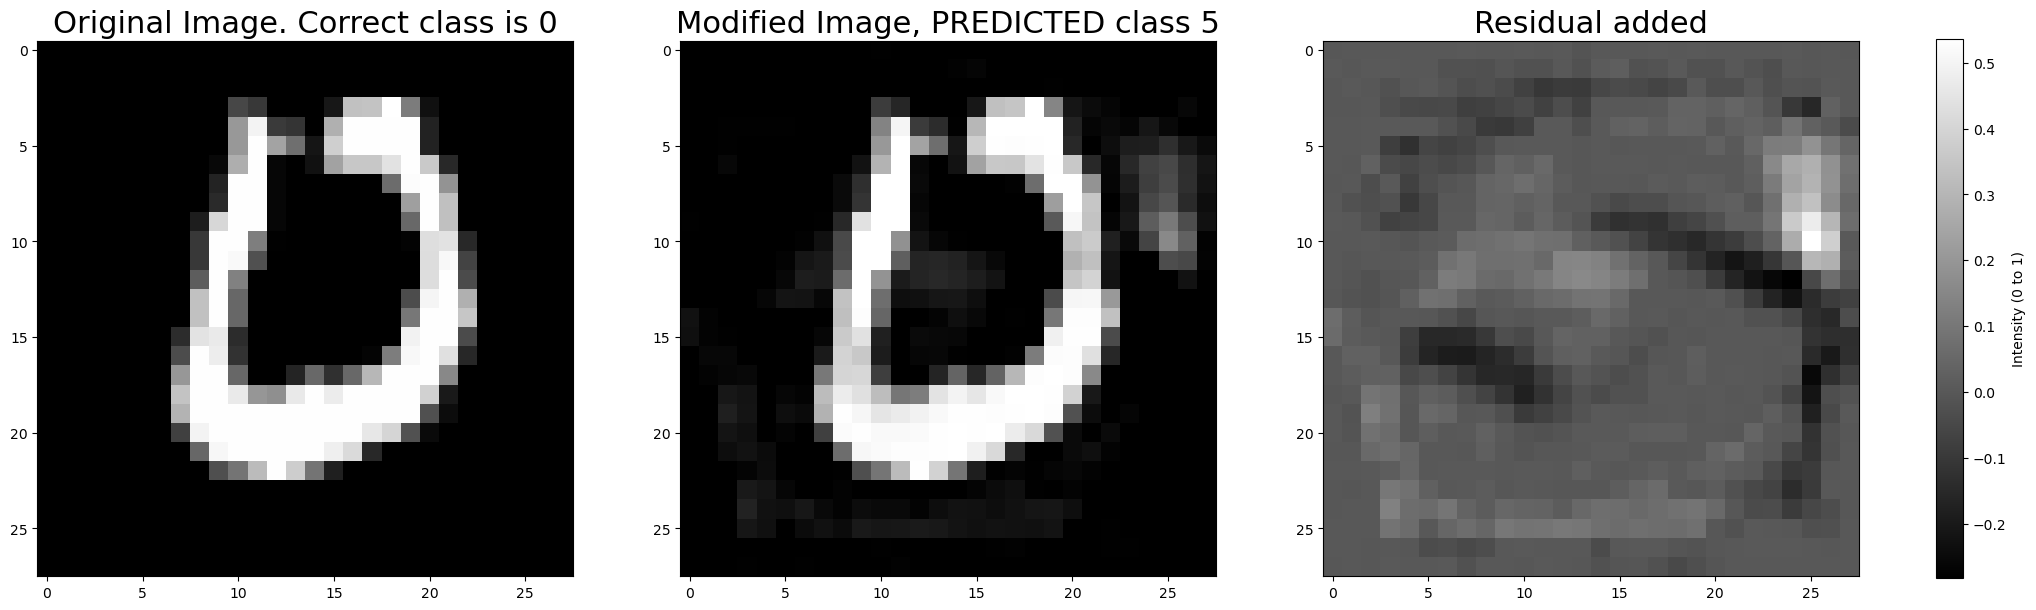

for image 6426 of true label 0 and false label 5 the convergence is: True
for image 4043 of true label 0 and false label 9 the convergence is: False
for image 9930 of true label 0 and false label 7 the convergence is: False


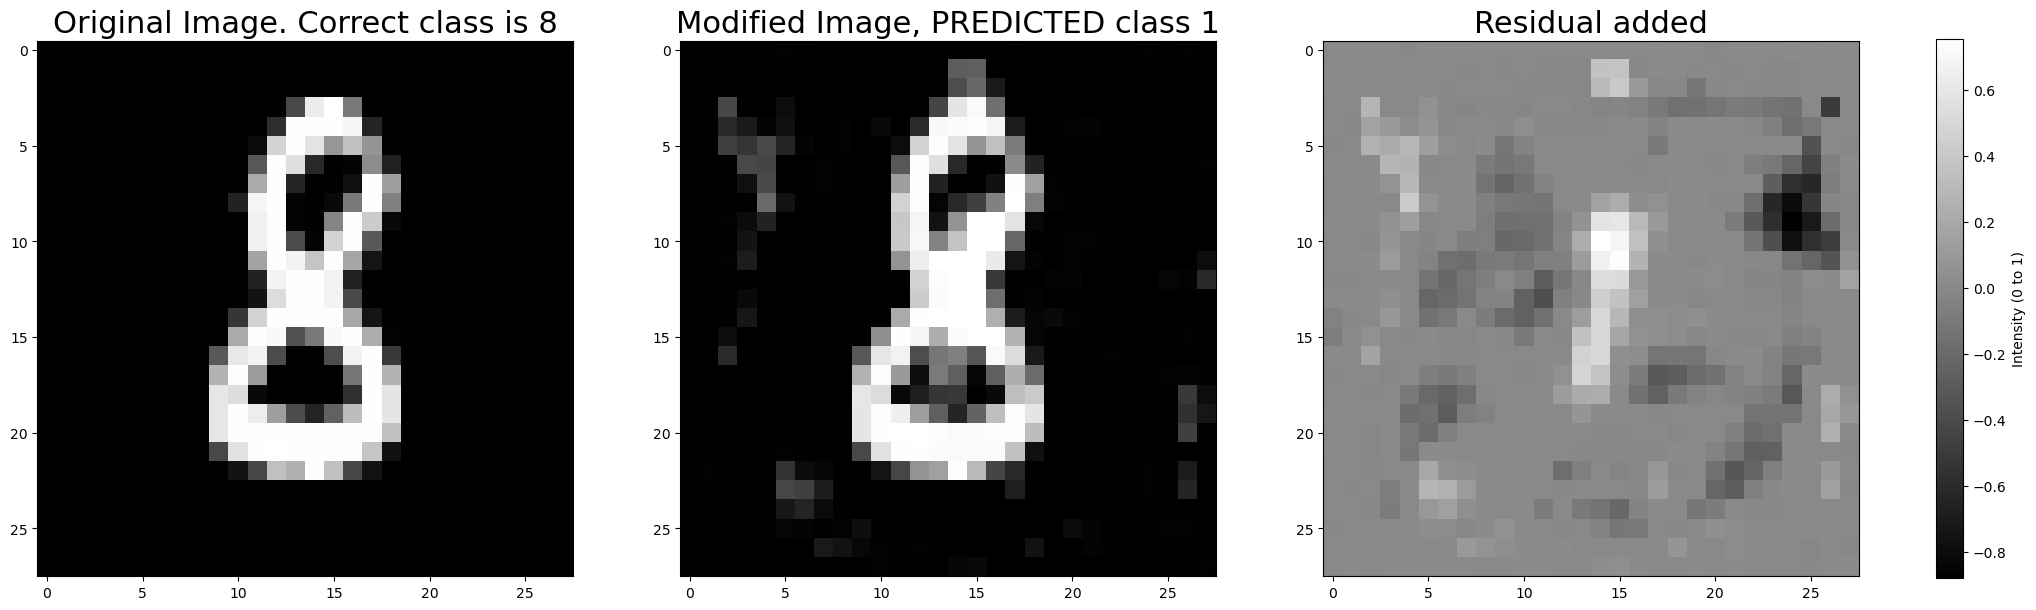

for image 6347 of true label 8 and false label 1 the convergence is: True


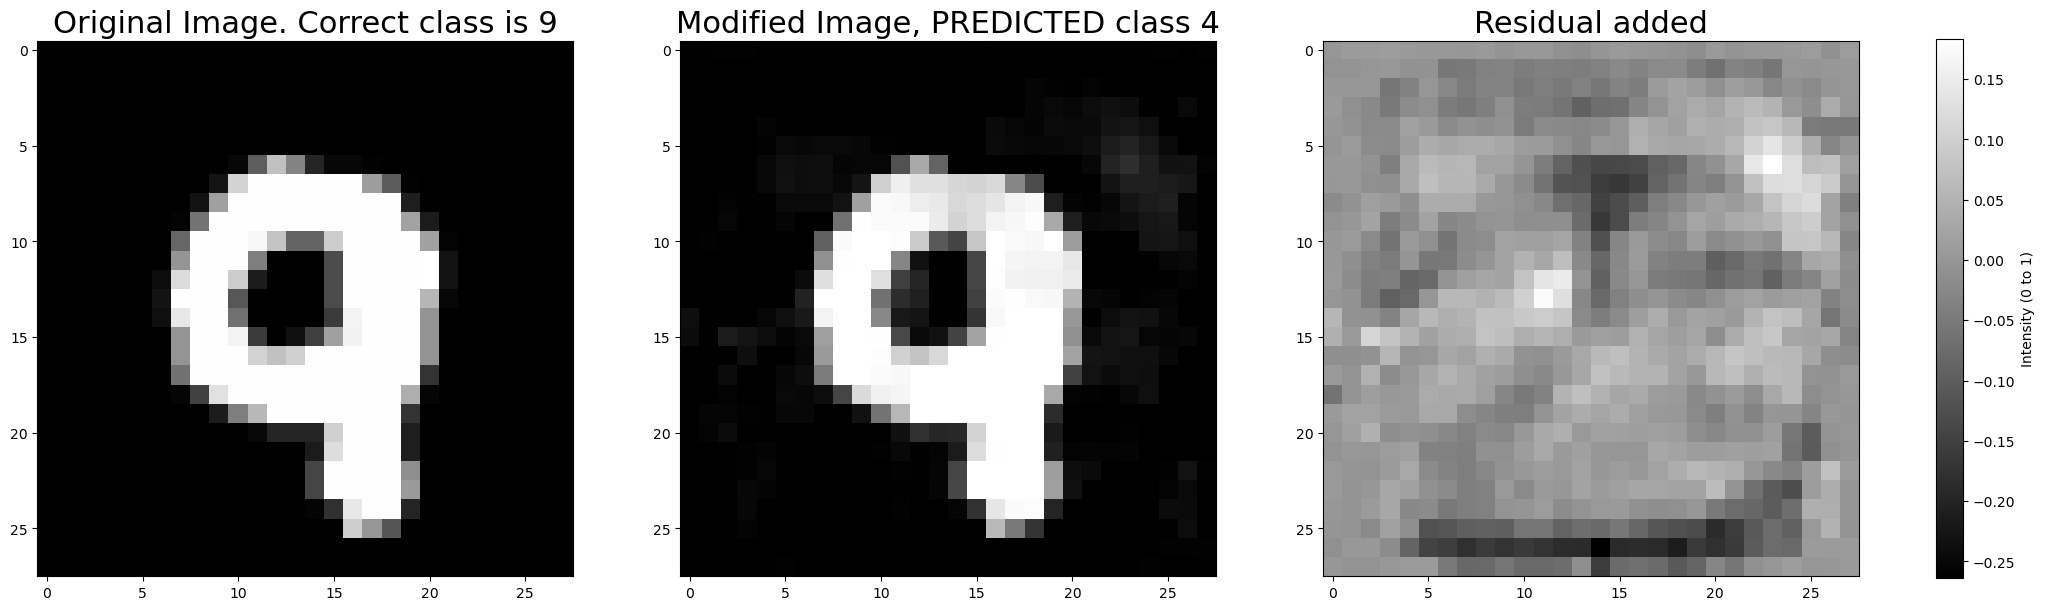

for image 1853 of true label 9 and false label 4 the convergence is: True
for image 1875 of true label 7 and false label 5 the convergence is: False
for image 8670 of true label 9 and false label 1 the convergence is: False
for image 3950 of true label 9 and false label 6 the convergence is: False


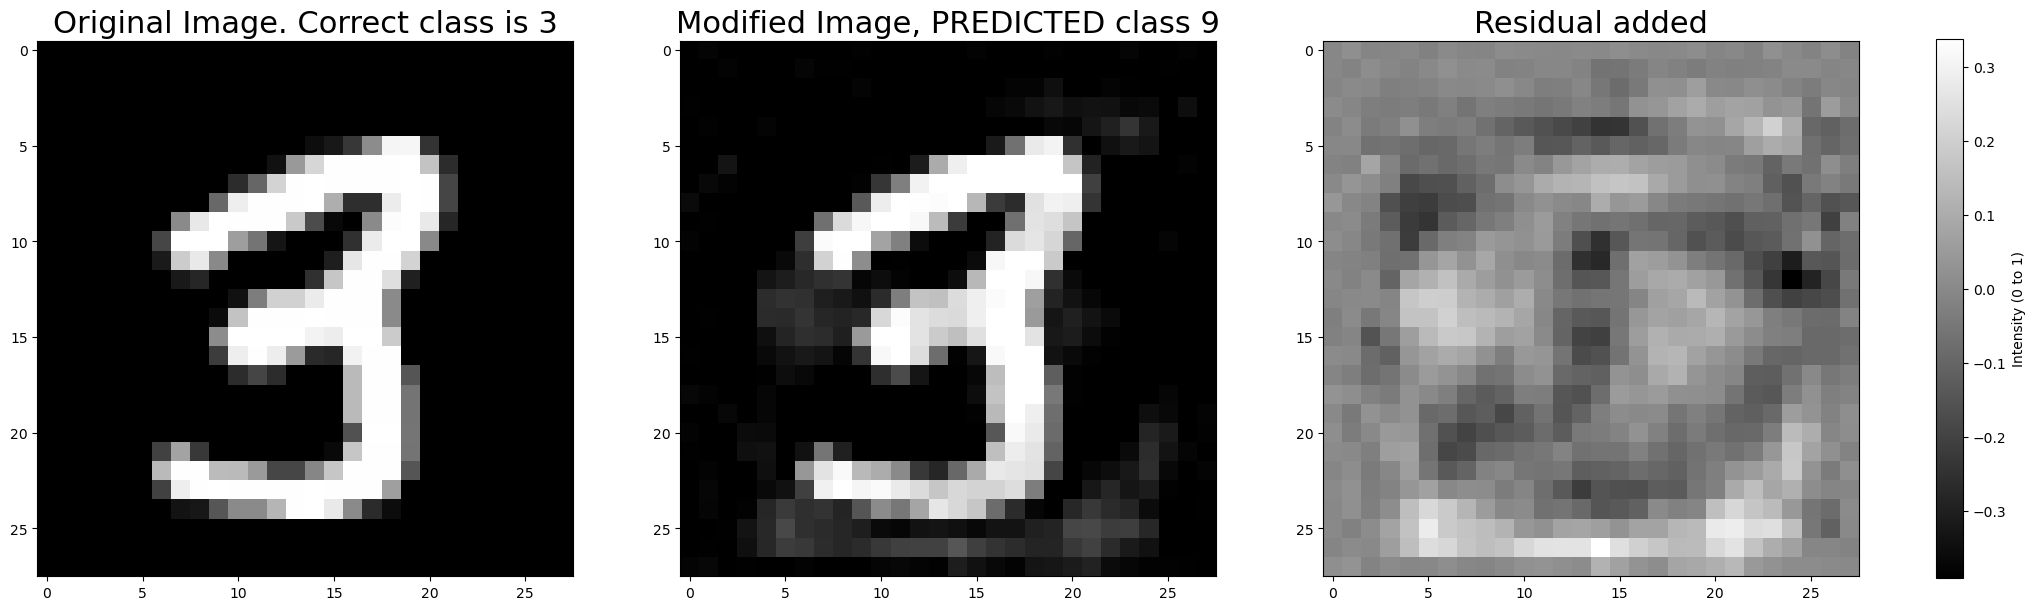

for image 6432 of true label 3 and false label 9 the convergence is: True
for image 3915 of true label 4 and false label 7 the convergence is: False
for image 3346 of true label 0 and false label 7 the convergence is: False
for image 5629 of true label 2 and false label 3 the convergence is: False
for image 7117 of true label 3 and false label 6 the convergence is: False
for image 5880 of true label 1 and false label 6 the convergence is: False


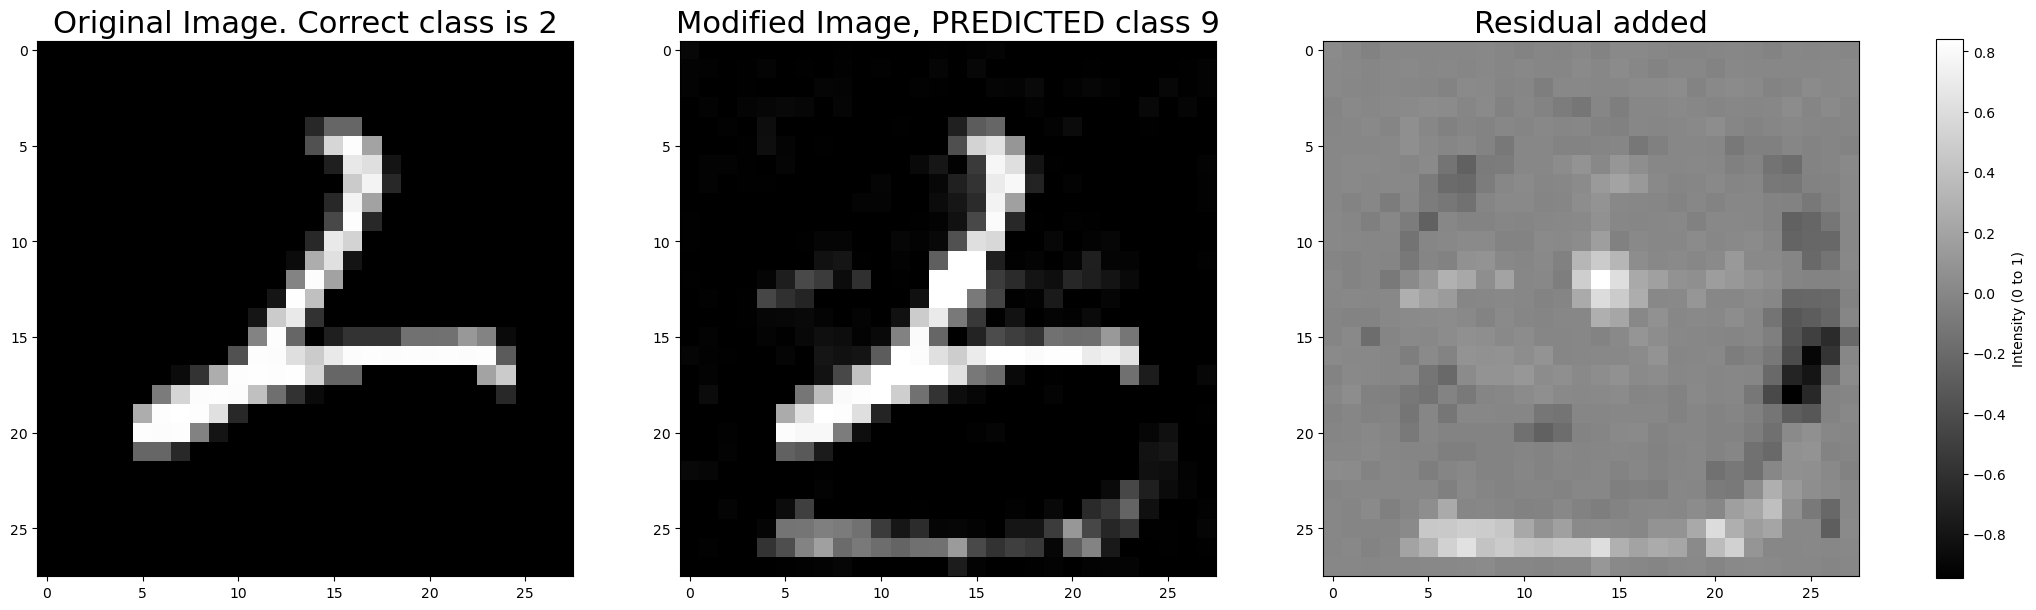

for image 43 of true label 2 and false label 9 the convergence is: True
for image 8336 of true label 6 and false label 5 the convergence is: False
for image 8978 of true label 0 and false label 1 the convergence is: False
for image 967 of true label 1 and false label 6 the convergence is: False
for image 1437 of true label 4 and false label 8 the convergence is: False
for image 2566 of true label 3 and false label 9 the convergence is: False
for image 1727 of true label 3 and false label 8 the convergence is: False
for image 7960 of true label 7 and false label 2 the convergence is: False
for image 6034 of true label 3 and false label 2 the convergence is: False
for image 8029 of true label 0 and false label 7 the convergence is: False
for image 6186 of true label 5 and false label 3 the convergence is: False
for image 8774 of true label 5 and false label 9 the convergence is: False


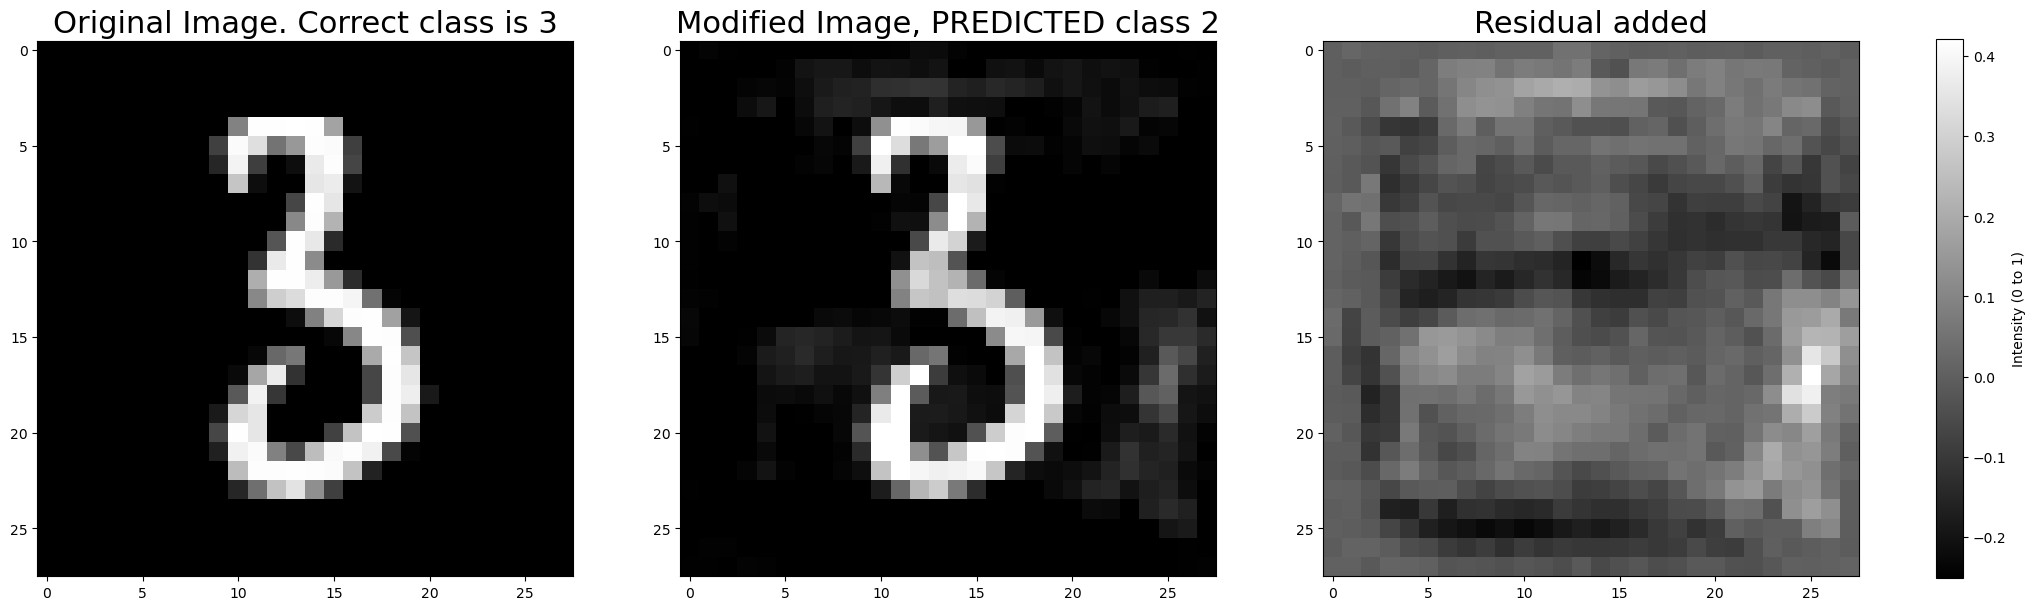

for image 2025 of true label 3 and false label 2 the convergence is: True


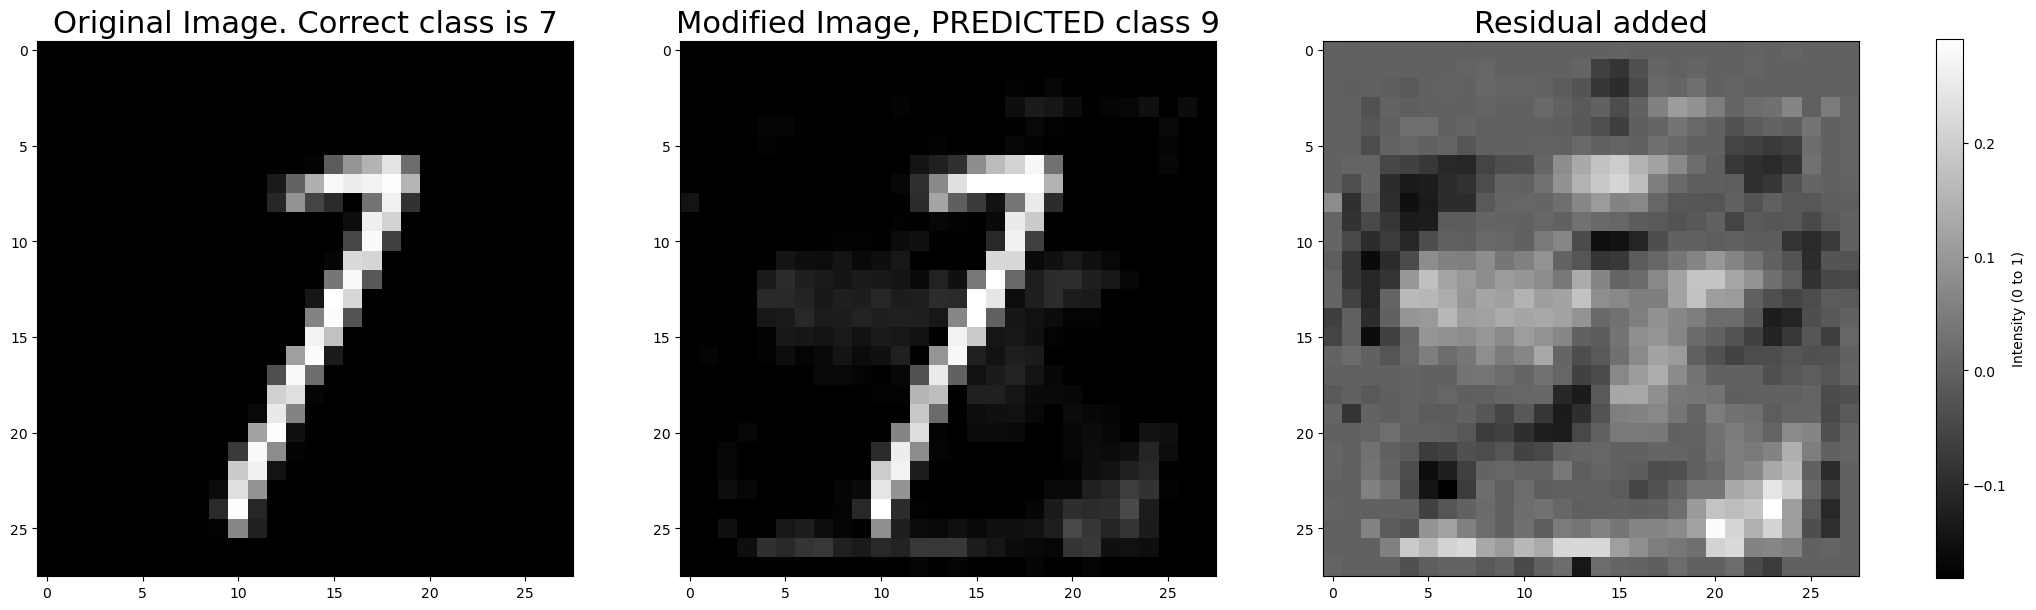

for image 1716 of true label 7 and false label 9 the convergence is: True
for image 8011 of true label 4 and false label 8 the convergence is: False


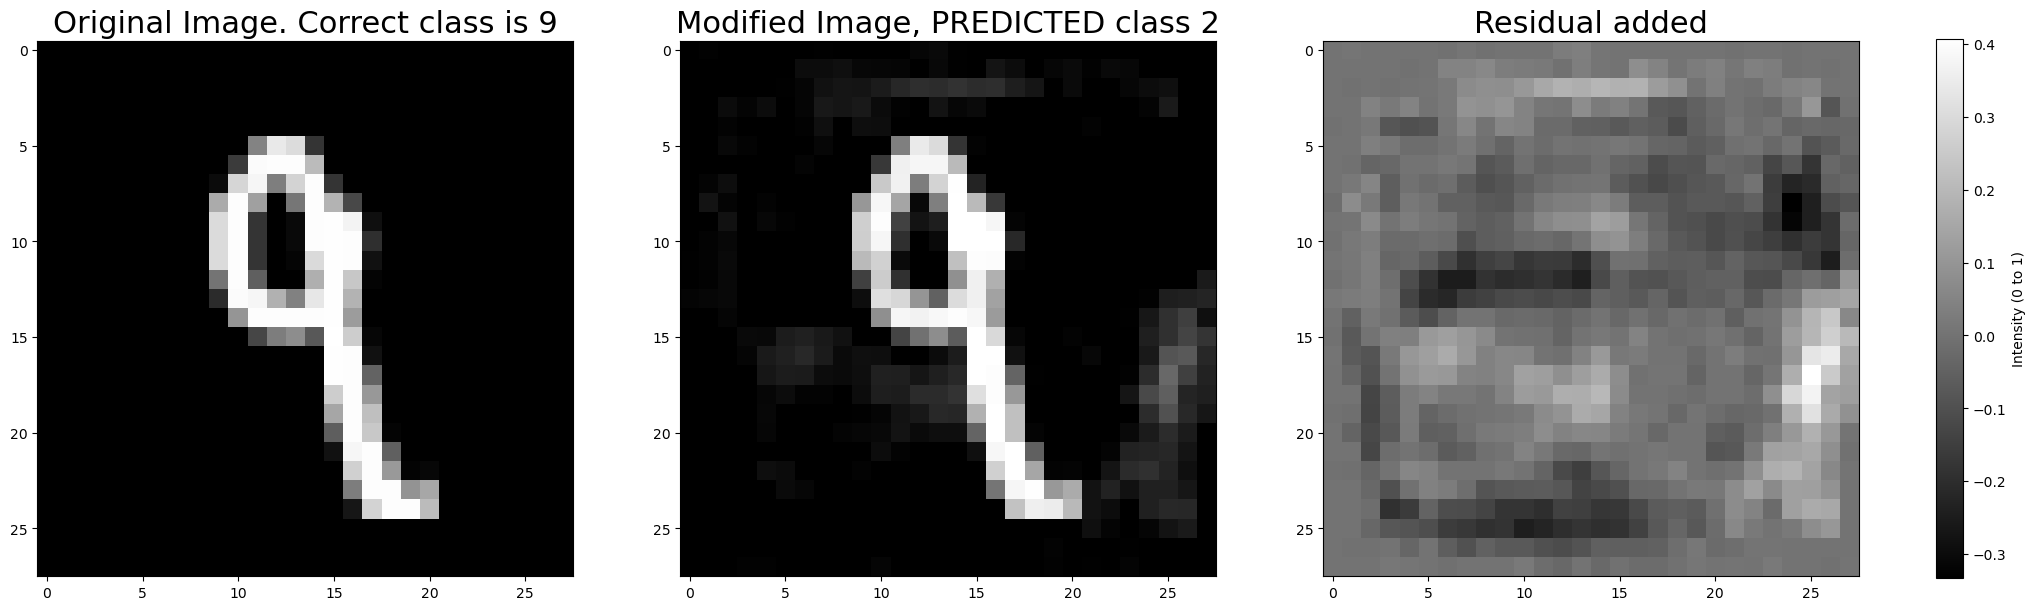

for image 264 of true label 9 and false label 2 the convergence is: True
for image 262 of true label 7 and false label 8 the convergence is: False
for image 8730 of true label 0 and false label 9 the convergence is: False


In [150]:
np.random.seed(20)
images = np.random.choice(len(mnist_test), 50)
adversarial_examples = []
images[0] = 666
all_rs=[]
for img in images : 
    testI, testY = mnist_test.__getitem__(img)
    testI=testI.to(device)
    r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
    label=int(np.random.choice([i for i in range(1, 10) if i != testY])) # manually chosen target class label different from true one
    l = torch.tensor([label]).to(device)  
    l=l.to(device)
    l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
    c = initial_c #initial_c = 0.000001  # Initial value of c
    iter=0
    while (c <= max_c) and (iter <= max_iter_search):    
        # Define the optimizer (Box-Constrained L-BFGS)
        optimizerLBFGS = optim.LBFGS([r], lr=lr_LBFGS, max_iter=max_iter_LBFGS, line_search_fn='strong_wolfe')
        def closure():
            optimizerLBFGS.zero_grad()
            loss = objective(c, r, testI, l)
            loss.backward()
            return loss

        # Perform optimization
        optimizerLBFGS.step(closure)


        # Evaluate the condition f(x + r) = l
        with torch.no_grad():
            x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)

        # Check if the condition f(x + r) = l is satisfied
        if predicted_label == l:
            adversarial_examples.append((x_r, testY, l )) # adding the misleading image
            # print(testY, l)
            break
        c *= mult_c  # Adjust step size for line search
        iter=iter+1
    if (c > max_c) or (iter > max_iter_search):
        cvgce = False
    else:
        cvgce = True
        plot_results(testI, r, x_r, testY, l, fail=False)
    all_rs.append(torch.norm(r, p=1))
    print('for image', img, 'of true label',testY, 'and false label',  label, 'the convergence is:', cvgce)

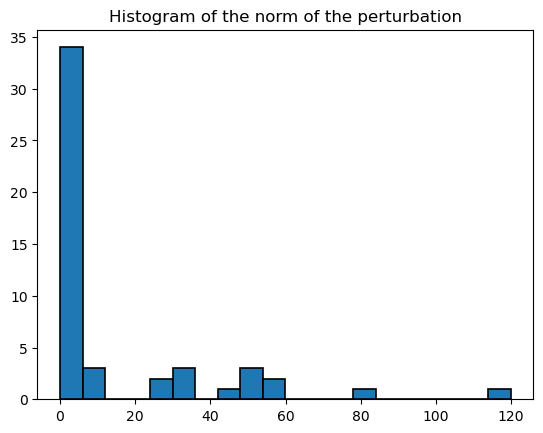

In [125]:
plt.hist([elt.detach().numpy() for elt in all_rs], bins=20, edgecolor='black', linewidth=1.2)
plt.title('Histogram of the norm of the perturbation')
plt.show()

Answer : 

The algorithm does not always converge. It even converges rarely.  The residual added is sometimes very small but can also be very big and make the image completely different from a number. I would face difficulties to say if the image obtained belongs to the first or the second class. Sometimes however, I would say that the image belongs to the first class, but the network labells it as the second class (for instance image 6426 which is disturbed to make the network labell it as a 5, which I can't understand, because it is very close to the original image )

**Question** What if you try with different networks ? Test with al least another network (i.e., change hidden_sizes) and see if the previous conclusions are still confirmed. 

Furthermore, check the cross-network performance. This means:
- produce a set of adversarial instances for a given network (samples that are visually similar to the original class but recognised by the network as belonging to a different class)
- check if these adversarial examples are also wrongly classified by the other network

Which conclusions can you draw from these results ? Please comment on that.

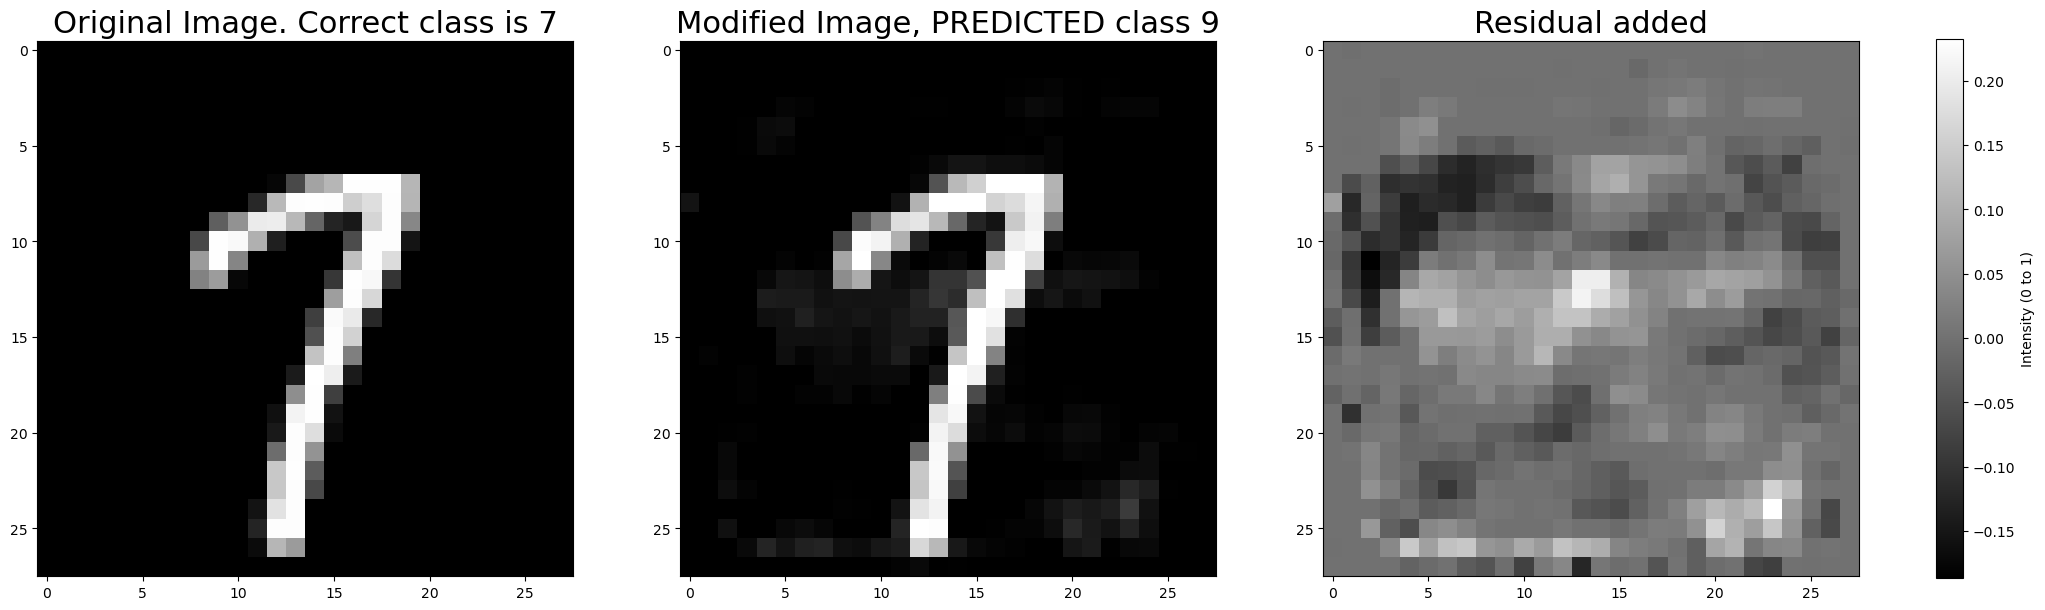

for image 666 of true label 7 and false label 9 the convergence is: True
for image 7391 of true label 4 and false label 3 the convergence is: False
for image 7068 of true label 6 and false label 8 the convergence is: False
for image 9620 of true label 9 and false label 4 the convergence is: False
for image 3915 of true label 4 and false label 3 the convergence is: False


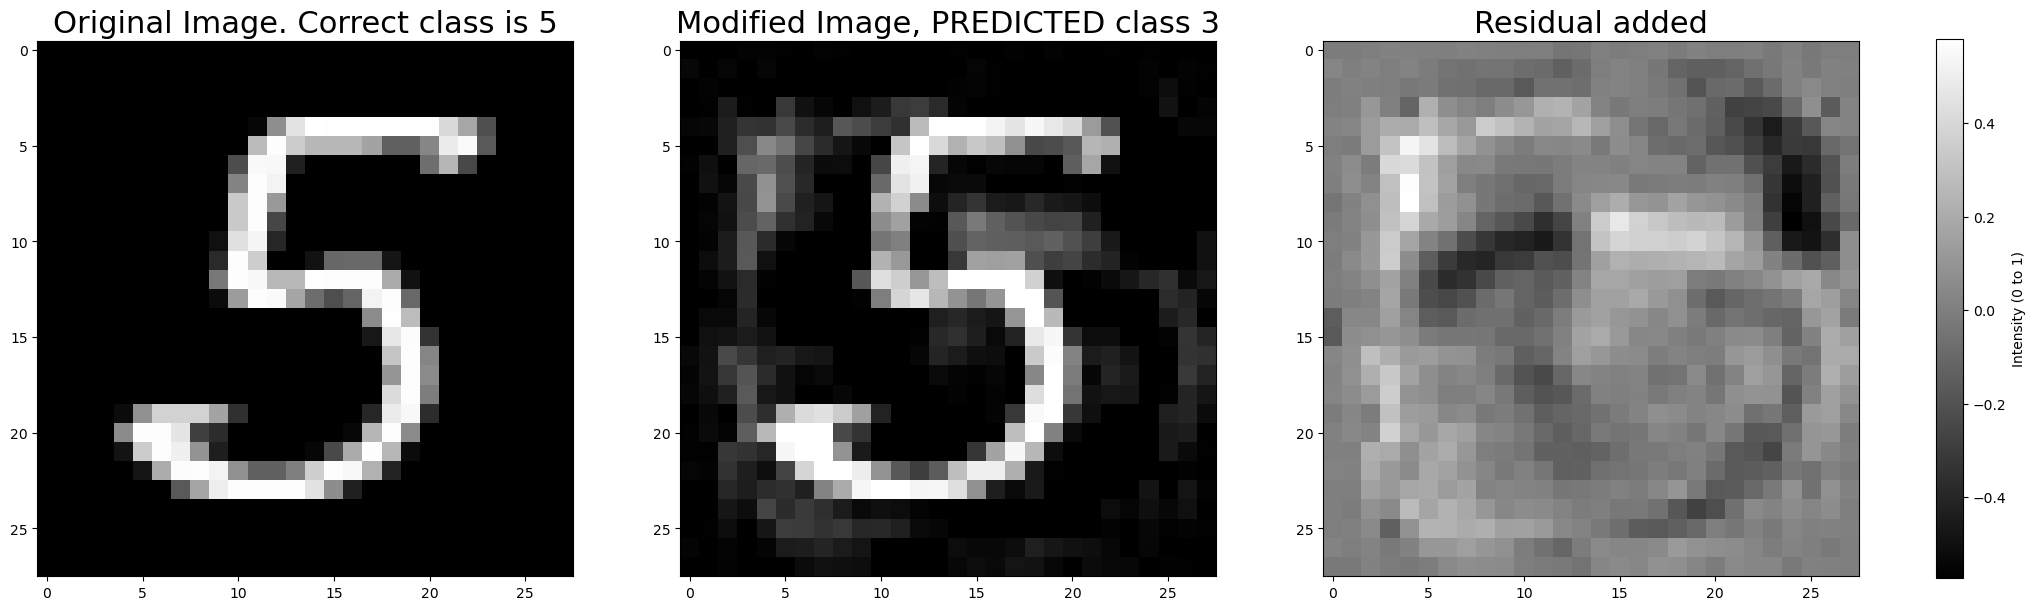

for image 5910 of true label 5 and false label 3 the convergence is: True


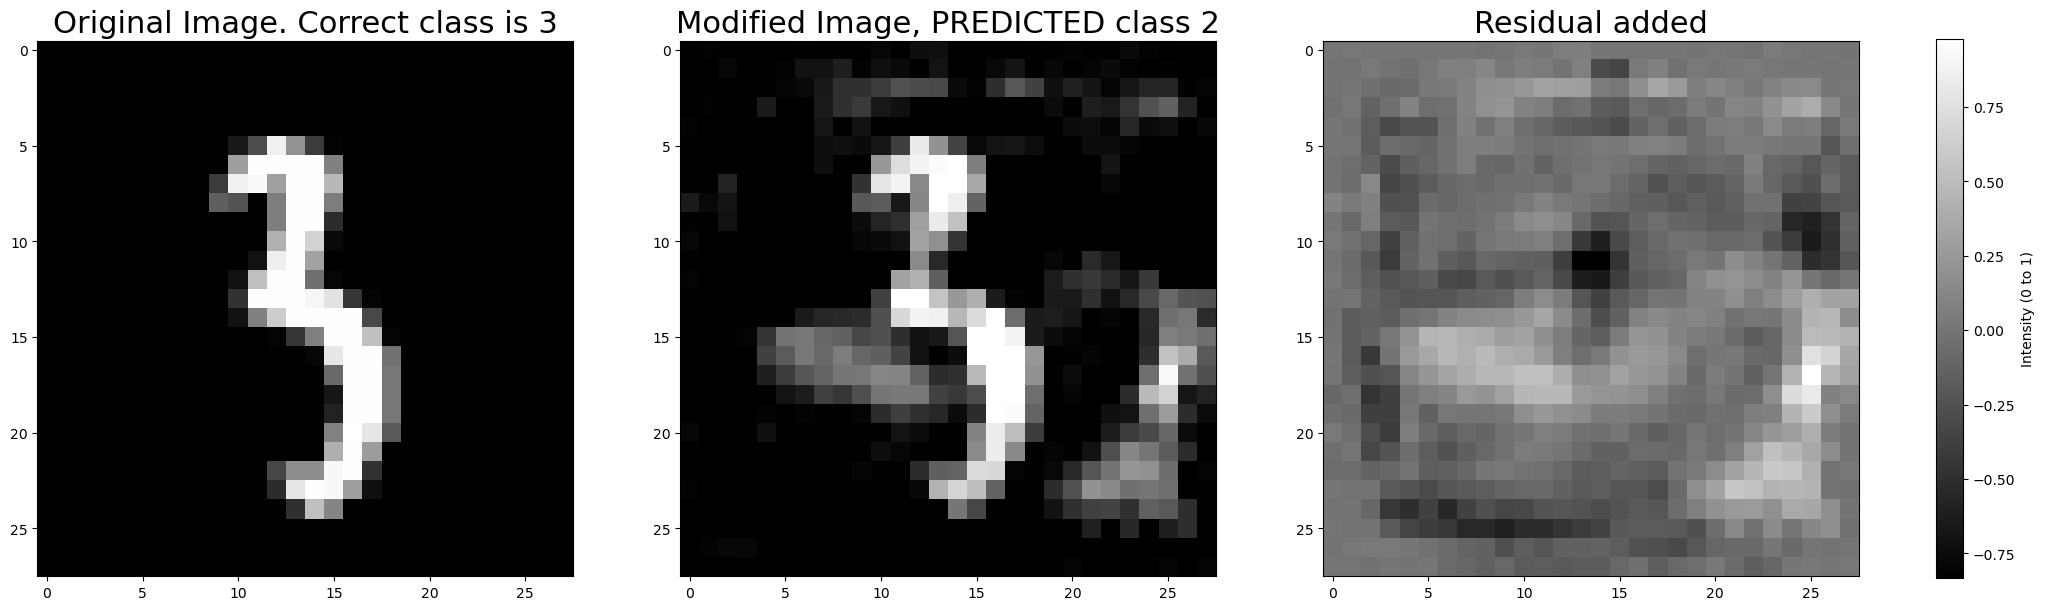

for image 1607 of true label 3 and false label 2 the convergence is: True
for image 3234 of true label 4 and false label 7 the convergence is: False
for image 8744 of true label 6 and false label 3 the convergence is: False
for image 5589 of true label 8 and false label 2 the convergence is: False


In [142]:
# trying with another network
np.random.seed(20)
images = np.random.choice(len(mnist_test), 50)[:10]
images[0] = 666
all_rs=[]
for img in images : 
    testI, testY = mnist_test.__getitem__(img)
    testI=testI.to(device)
    r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
    label=int(np.random.choice([i for i in range(1, 10) if i != testY])) # manually chosen target class label different from true one
    l = torch.tensor([label]).to(device)  
    l=l.to(device)
    l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
    c = initial_c #initial_c = 0.000001  # Initial value of c
    iter=0
    while (c <= max_c) and (iter <= max_iter_search):    
        # Define the optimizer (Box-Constrained L-BFGS)
        optimizerLBFGS = optim.LBFGS([r], lr=lr_LBFGS, max_iter=max_iter_LBFGS, line_search_fn='strong_wolfe')
        def closure():
            optimizerLBFGS.zero_grad()
            loss = objective(c, r, testI, l)
            loss.backward()
            return loss

        # Perform optimization
        optimizerLBFGS.step(closure)


        # Evaluate the condition f(x + r) = l
        with torch.no_grad():
            x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
            pred = model_2(x_r)
            predicted_label = torch.argmax(pred, dim=1)

        # Check if the condition f(x + r) = l is satisfied
        if predicted_label == l:
            break
        c *= mult_c  # Adjust step size for line search
        iter=iter+1
    if (c > max_c) or (iter > max_iter_search):
        cvgce = False
    else:
        cvgce = True
        plot_results(testI, r, x_r, testY, l, fail=False)
    all_rs.append(torch.norm(r, p=1))
    print('for image', img, 'of true label',testY, 'and false label',  label, 'the convergence is:', cvgce)

We observe that this other network does not converge exactly on the same images. 

In [158]:
np.random.seed(20)
images = np.random.choice(len(mnist_test), 300)
adversarial_examples = []
images[0] = 666
all_rs=[]
for i in tqdm(range((len(images)))) :
    img = images[i] 
    testI, testY = mnist_test.__getitem__(img)
    testI=testI.to(device)
    r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
    label=int(np.random.choice([i for i in range(1, 10) if i != testY])) # manually chosen target class label different from true one
    l = torch.tensor([label]).to(device)  
    l=l.to(device)
    l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
    c = initial_c #initial_c = 0.000001  # Initial value of c
    iter=0
    while (c <= max_c) and (iter <= max_iter_search):    
        # Define the optimizer (Box-Constrained L-BFGS)
        optimizerLBFGS = optim.LBFGS([r], lr=lr_LBFGS, max_iter=max_iter_LBFGS, line_search_fn='strong_wolfe')
        def closure():
            optimizerLBFGS.zero_grad()
            loss = objective(c, r, testI, l)
            loss.backward()
            return loss
        optimizerLBFGS.step(closure)
        with torch.no_grad():
            x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)
        if predicted_label == l:
            adversarial_examples.append((x_r, testY, l )) # adding the misleading image
            # print('added')
            # print(testY, l)
            break
        c *= mult_c  # Adjust step size for line search
        iter=iter+1
    if (c > max_c) or (iter > max_iter_search):
        cvgce = False
    else:
        cvgce = True
    all_rs.append(torch.norm(r, p=1))


100%|██████████| 300/300 [22:16<00:00,  4.46s/it]


In [160]:
same_error=0
different_error=0
good=0
for elt  in adversarial_examples: 
    x_r = elt[0]
    real_label=elt[1]
    fake_label=elt[2]
    pred_2 = model_2(x_r)
    pred_2 = torch.argmax(pred_2, dim=1).item()
    # print('the true label is', real_label, ' The model 1 predicts', fake_label.item(), 'and the model 2 predicts', pred_2)
    if fake_label.item() == pred_2 : 
        same_error+=1
    elif real_label == pred_2 :
        good+=1
    else : 
        different_error +=1
print()
print('the number of times the two models make the same error is', same_error)
print('the number of times the two models make different errors is', different_error)
print('the number of times the second model is good but not ths first is ', good)


the number of times the two models make the same error is 41
the number of times the two models make different errors is 7
the number of times the second model is good but not ths first is  22


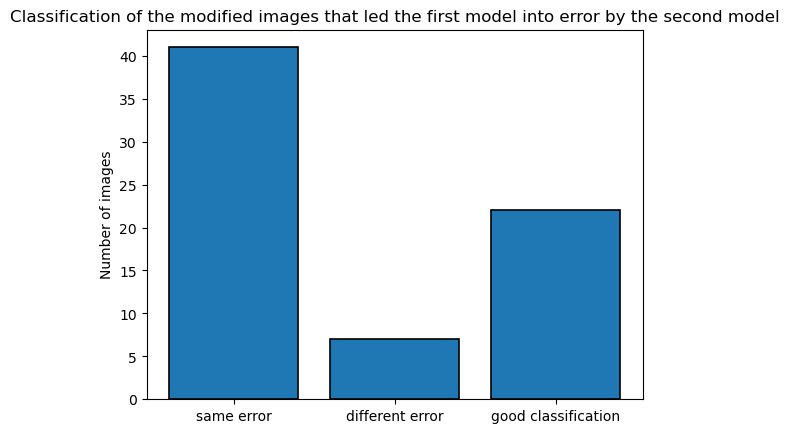

In [7]:
plt.bar(['same error', 'different error', 'good classification'], [same_error, different_error, good], edgecolor='black', linewidth=1.2)
plt.ylabel('Number of images')
plt.title( 'Classification of the modified images that led the first model into error by the second model')
plt.show()    

We observe that when the model 1 makes an error, the model 2 wether makes the same error or has the good prediction but makes rarely a different error. It would mean that the models learn roughly the same boarders between classes in the space of images.  

Instead than using L-BFGS to find adversarial examples we could also use a backpropagation method such as Adam, where you could optimize only r or both r and c. 

**Question** Change the previous code to use Adam instead than L-BFGS for the optimization. This means that you don't do anymore a line-search to find the minimum $c$ (no more closure). You can either fix $c$ and estimate only $r$ or estimate both. Try these two solutions and comment on that. Does it work properly ? If not, try to change the loss function. Would you add a regularization term ? If yes, which one and why ? Does it work better ? Please comment on that.

In [107]:
def objective_bis(c, r, x, l, penalty):
    los = c * torch.norm(r, p=1) + loss_model(model(x + r), l)
    return los + torch.norm(r, p=1)*penalty
    # return los + penalty * c 

def perform_optim(optimizer, line_search : bool, penalty : float, l : int): 
    
    iter = 0 
    c = 0.000001
    while  (iter <= max_iter_search):    
        optimizer.zero_grad() 
        loss = objective_bis(c, r, testI, l, penalty)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)
        if predicted_label == l:
            print(f"Found c = {c:.6f} satisfying f(x + r) = l")
            iter=iter+1
            break
        else:
            iter=iter+1
        if line_search: 
            c *= 1.01 # Adjust step size for line search
    if (c > max_c) or (iter > max_iter_search):
        print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
        #print(f"Perturbation r: {r}")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
        plot_results(testI, r, x_r, testY, l, fail=True)
    else:
        print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
        #print(f"Perturbation r: {r}")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

        plot_results(testI, r, x_r, testY, l, fail=False)

optimizing  only r, no penalty 

Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 3 iterations
Norm Perturbation |r|: 106.72270202636719


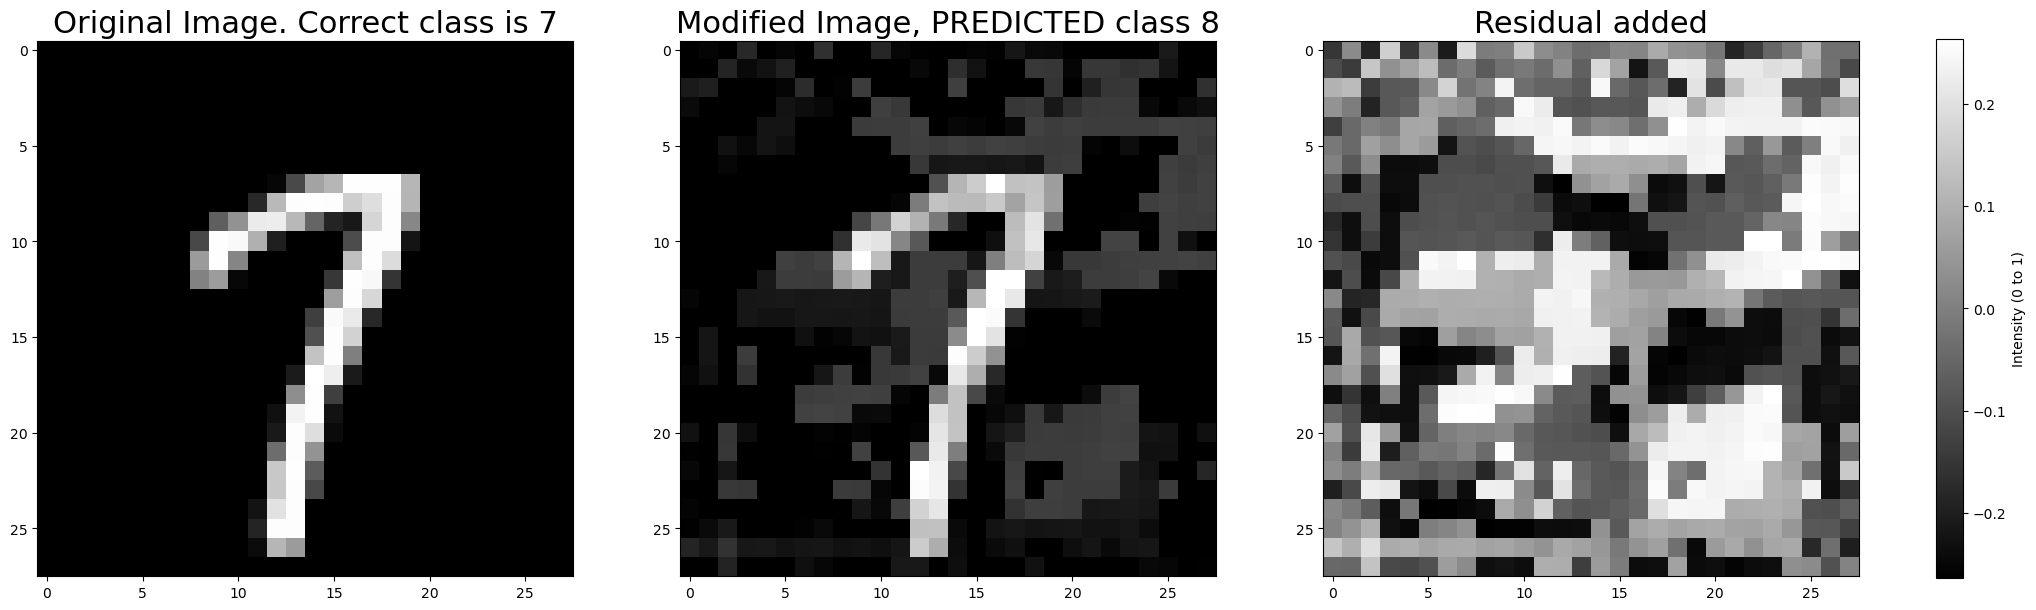

optimizing  only r, penalty  = 1e-4

Found c = 0.000004 satisfying f(x + r) = l
Optimization succeeded with c = 0.000004 in 142 iterations
Norm Perturbation |r|: 39.9805908203125


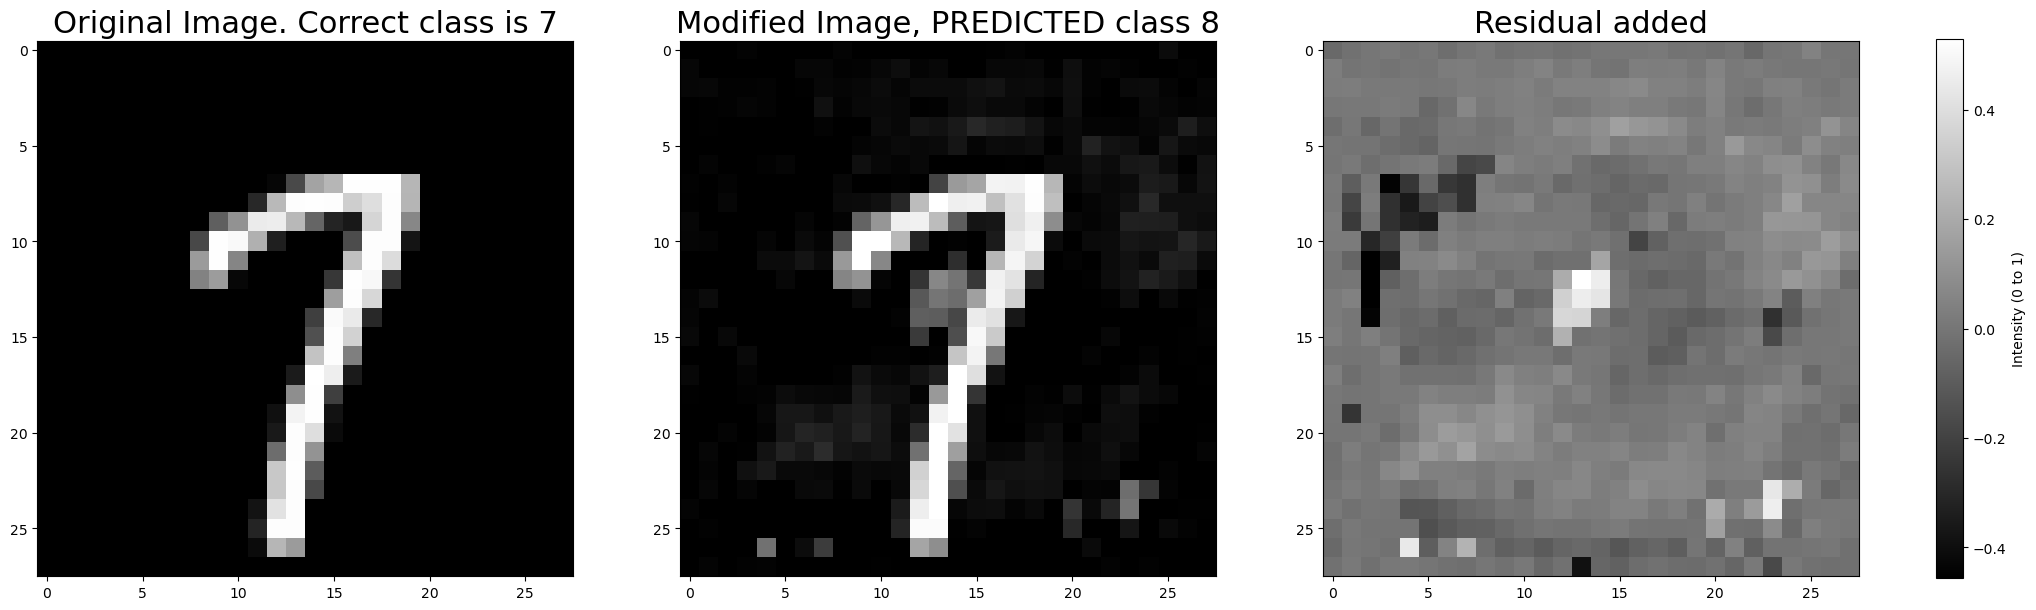

optimizing both r and c 

Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 166 iterations
Norm Perturbation |r|: 112.82382202148438


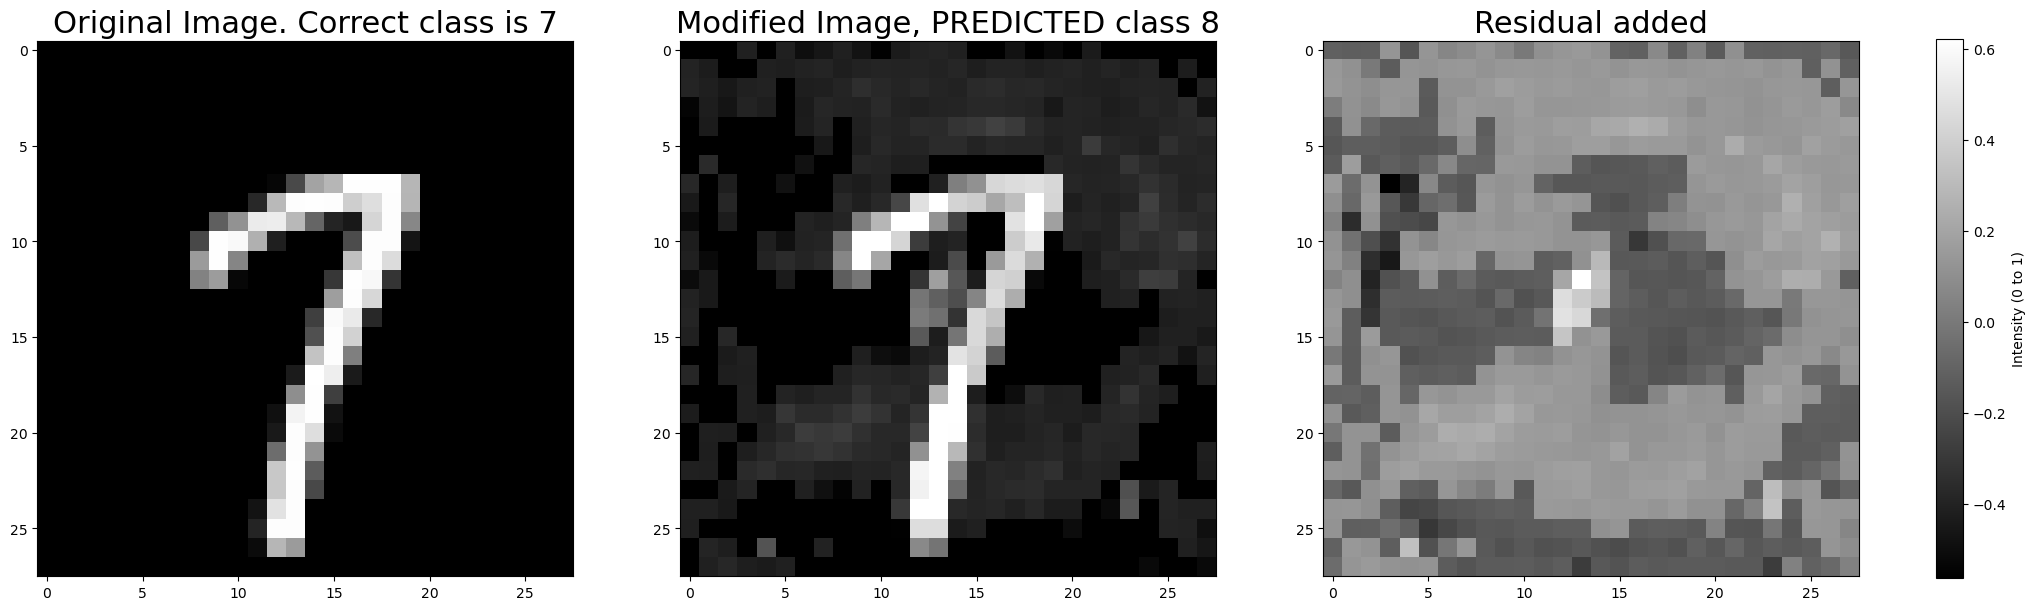

In [109]:
testI=testI.to(device)
label=8 # manually chosen target class label different from true one
l = torch.tensor([label]).to(device)  
l=l.to(device)
l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss


print('optimizing  only r, no penalty ')
print()
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
optimadam = optim.Adam([r], lr=lr_LBFGS)
perform_optim(optimadam, True, 0, l)

print('optimizing  only r, penalty  = 1e-4')
print()
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
optimadam = optim.Adam([r], lr=lr_LBFGS)
perform_optim(optimadam, True, 1e-4, l)

print('optimizing both r and c ')
print()
c = 0.000001
c = torch.tensor([c], requires_grad=True, device=device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
optimadambis = optim.Adam([r, c], lr=lr_LBFGS)
perform_optim(optimadambis, False, 1e-4, l)

Adding a penalty on the norm of r works quite well. I have found it with a grid search on r. There is no need to find a performant norm as the optimization with r is enough to find close images that are wrongly labelled. The regularization (norm1 of r) enables to get better performances as it prevents to have too big r that diverges : the algorithm has to find a r very close to the original image. This could also have been done with a  regularization term on c, which has exactly the same role. However, optimizing only r with no penalty does not work at all.

# Fast Gradient Sign Attack (FGSM)

Another famous method to create adversarial examples is Fast Gradient Sign Attack (FGSM). Let $\theta$ be the parameters of a model, x the input image to the model, y its class and J(θ, x, y) the cost used to train the neural network. Usually, when training a model, we compute the gradient of the cost function with respect to the parameters of the model and update them based on the oppositve (i.e., negative) direction of the gradient to decrease the loss. Here, we can replicate the same reasoning but using the pixel values of the input image instead than the model's parameters and using the gradient direction (i.e., positve) to actually maximize the loss. The idea is thus to modify the pixel values so that the loss is maximized and not minimized. In this way, the perturbation should change the image so that it will be misclassified by the model. In order to keep the changes small, possibly imperceptible to naked eye, we only use the sign of the gradient and multiply it by a small $\epsilon$ value. Mathematically, the adversarial example is estimated using:
 $$x_r =x + \epsilon \text{sign}(\Delta_x J(\theta, x, y))$$

 The gradient can easily be computed using backpropagation (Adam).


[*]` Ian J. Goodfellow, Jonathon Shlens & Christian Szegedy Explaining and harnessing adversarial examples. ICLR. 2015`

Let's load an image.

In [ ]:
# Parameters
index=10
testI, testY = mnist_test.__getitem__(index)
X = testI.unsqueeze(0).to(device)
print(X.shape)
X.requires_grad = True # Important for attack
Y=torch.tensor([testY]).to(device)

And plot it.

In [ ]:
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

Complete the code by fixing a `eps`value.

In [ ]:
eps = XXXXXXX # perturbation size

# Forward pass of X through the model
pred_original = model(X)  
original_class=XXXXXXXX

# Compute loss
cost = XXXXXXXX

# Zero existing (previous) gradients
model.zero_grad()

# Compute gradients
cost.backward()

# FGSM attack code
Xr = XXXXXXX
Xr = XXXXXXX

# Re-classify the perturbed image
pred_perturbed = model(Xr)
perturbed_class=XXXXXXXXXX    

# Print results
print(f"Original Class: {original_class.item()}, Perturbed Class: {perturbed_class.item()}")

r=eps*X.grad.data.sign()

if original_class.item()==perturbed_class.item():
    print(f"Optimization failed")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=True)   
else:
    print(f"Optimization succesfull")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=False)

Now, to find the best `eps`value, you will code a function and evalute the successful rate for each `eps`value (number of images where an adversarial examples has been successfully created). 

**Question**: What's the best `eps`value ? Are the changes imperceptible to a naked human eye ?

In [ ]:
def fgsm_attack(X, Y, model, loss_model, eps):

    XXXXXXXXXX 

    return Xr, original_class, perturbed_class, r

# Accuracy counter
adv_examples = []
succes=0
eps = XXXXXXX # perturbation size

# Loop over all examples in test set
for X_batch, Y_batch in test_loader:  # Iterate through batches
    for X, Y in zip(X_batch, Y_batch):
        
        XXXXXXXXXX

# Calculate final accuracy for this epsilon
Adv_acc = XXXXXXX
print(f"Using epsilon: {eps} we succesfully create {Adv_acc} % adversariale examples")   

# Plot one example
index=0
plot_results(XXXXXXX)